In [364]:
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
from scipy.stats import gaussian_kde
from scipy import stats
from Bio.Seq import Seq
import seaborn as sn

In [365]:
lsize=13
titlesize=14
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'),'whis':[5, 95],'flierprops':dict(marker='.',markersize=2.5, alpha=0.2, color="#424242")}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
bar_unintended_kwargs = {'color':'#ff9e9e', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = 1.5

## Create ML model comparison chart

In [366]:
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\baseline_evaluation_results_2022-07-21_15-18-07\\randomsearchCV\\baseline_models_averageedited_individual_clamped_res\\"

modelbenchmarkdf = pd.read_csv(path+'baseline_avgruns.csv')
modelbenchmarkdf = modelbenchmarkdf[modelbenchmarkdf['model_name'].str.contains("norm_False")]
modelbenchmarkdf['model_type'] = modelbenchmarkdf['model_name'].apply(lambda x: x[:-12])
modelnames = list(modelbenchmarkdf['model_type'])
modelbenchmarkdf

spearmansummary = list(modelbenchmarkdf['avg_spearman_score'])
spearmansummary.reverse()
spearmanstdv = list(modelbenchmarkdf['spearman_score_std'])
spearmanstdv.reverse()

modelnames[4] = 'Histogram-based\nGradient Boosting'  # add line break for HistGradBoost
modelnames[5] = 'XGBoost'
modelnames.reverse()

path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44\\"

resdf = pd.read_csv(path+'res_df.csv')
deepbenchmarkdf = resdf[resdf['outcome_name'] == 'averageedited']
indelbenchmarkdf = resdf[resdf['outcome_name'] == 'averageindel']
averageindelspearmanscore = indelbenchmarkdf['spearman_score'].mean()
averageindelpearsonscore = indelbenchmarkdf['pear_score'].mean()
averagedeepscore = deepbenchmarkdf['spearman_score'].mean()
deepstdv = deepbenchmarkdf['spearman_score'].std()
spearmansummary.insert(0,averagedeepscore)
spearmanstdv.insert(0,deepstdv)
modelnames.insert(0,'PRIDICT AttnBiRNN')

In [367]:
modelshortnamelist = ['Ridge',
 'Lasso',
 'ElasticNet',
 'RandomForestRegressor',
 'HistGradientBoostingRegressor',
 'xgboost']

def list_files(directory):
    return [f for f in listdir(directory) if 'False_5runs.csv' in f]
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\baseline_evaluation_results_2022-07-21_15-18-07\\randomsearchCV\\baseline_models_averageedited_individual_clamped_res\\"

modellist = list_files(path)
for model in modellist:
    editing_spearman_individual_run_values = []
    indel_spearman_individual_run_values = []
    modelshortname = model.split('_')[0]
    ind = modelbenchmarkdf.index[modelbenchmarkdf['model_type'] == modelshortname].tolist()[0]
    fiverundf = pd.read_csv(path+model)
    for runnr in range(0,5):
        editing_spearman_individual_run_values.append(fiverundf.at[0,'run_'+str(runnr)])
        indel_spearman_individual_run_values.append(fiverundf.at[1,'run_'+str(runnr)])
        modelbenchmarkdf.at[ind,'editing_individual_spearman_run_'+str(runnr)] = fiverundf.at[0,'run_'+str(runnr)]

editingindividualdf = pd.DataFrame()        
modelbenchmarkdf = modelbenchmarkdf.sort_values(by=['avg_spearman_score'],ascending=False)
editing_spearman_individual_run_value_summary = []
namelist = []
for index, row in modelbenchmarkdf.iterrows():
    for runnr in range(0,5):
        editing_spearman_individual_run_value_summary.append(row['editing_individual_spearman_run_'+str(runnr)])
        namelist.append(row['model_type'])
    
pridict_individual_spearman_values = list(deepbenchmarkdf['spearman_score'])

for runnr in range(0,5):
    editing_spearman_individual_run_value_summary.insert(0,pridict_individual_spearman_values[runnr])
    namelist.insert(0,'PRIDICT')
    
editingindividualdf['names'] = namelist
editingindividualdf['editing_spearmanvalues'] = editing_spearman_individual_run_value_summary

In [368]:
basicmodelsdf = pd.DataFrame()
basicmodelsdf['labels'] = modelnames
basicmodelsdf['spearmanscore'] = spearmansummary
basicmodelsdf['spearmanstdv'] = spearmanstdv
basicmodelsdf = basicmodelsdf.sort_values(by='spearmanscore', ascending=False)
basicmodelsdf = basicmodelsdf.set_index('labels', drop=False)
basicmodelsdf

labels  \
labels                                                                   
PRIDICT AttnBiRNN                                    PRIDICT AttnBiRNN   
XGBoost                                                        XGBoost   
Histogram-based\nGradient Boosting  Histogram-based\nGradient Boosting   
RandomForestRegressor                            RandomForestRegressor   
Ridge                                                            Ridge   
Lasso                                                            Lasso   
ElasticNet                                                  ElasticNet   

                                    spearmanscore  spearmanstdv  
labels                                                           
PRIDICT AttnBiRNN                        0.851360      0.006351  
XGBoost                                  0.798290      0.013271  
Histogram-based\nGradient Boosting       0.795391      0.002384  
RandomForestRegressor                    0.768787      0.005241  
Ridge                                    0.653869      0.005042  
Lasso                                    0.653749      0.005147  
ElasticNet                               0.653719      0.005067

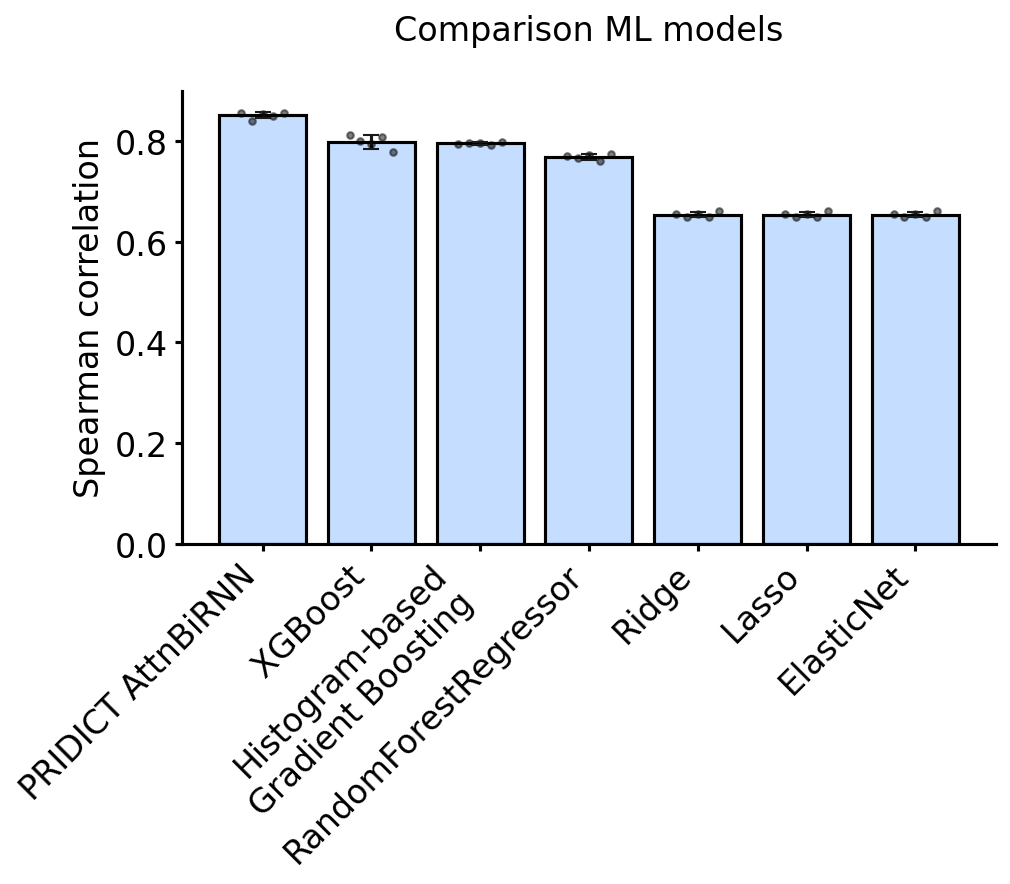

In [369]:
fig1, ax1 = plt.subplots(figsize = (7,4),dpi=150,sharex=True)
ax1.set_title('Comparison ML models\n', fontsize=16)
ax1.bar(basicmodelsdf['labels'],basicmodelsdf['spearmanscore'], yerr=basicmodelsdf['spearmanstdv'], **bar_kwargs)

x = list(basicmodelsdf['labels'])
y = editing_spearman_individual_run_value_summary
counter = 0
for i in range(len(x)):
    for runnr in range(5):
        ax1.scatter(i+(runnr/5-0.4)/2, y[counter], s=10, color='black',alpha=0.5,zorder=2)
        counter+=1

ax1.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax1.set_xticklabels(basicmodelsdf['labels'], ha="right")

ax1.set_ylabel('Spearman correlation', fontsize=16)
ax1.tick_params(axis='x', labelsize= 16, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= 16, width=1.5)
ax1.set_ylim(0, 0.9)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\02_ML_models\\'
plt.savefig(figurepath+'ml_model_comparison.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

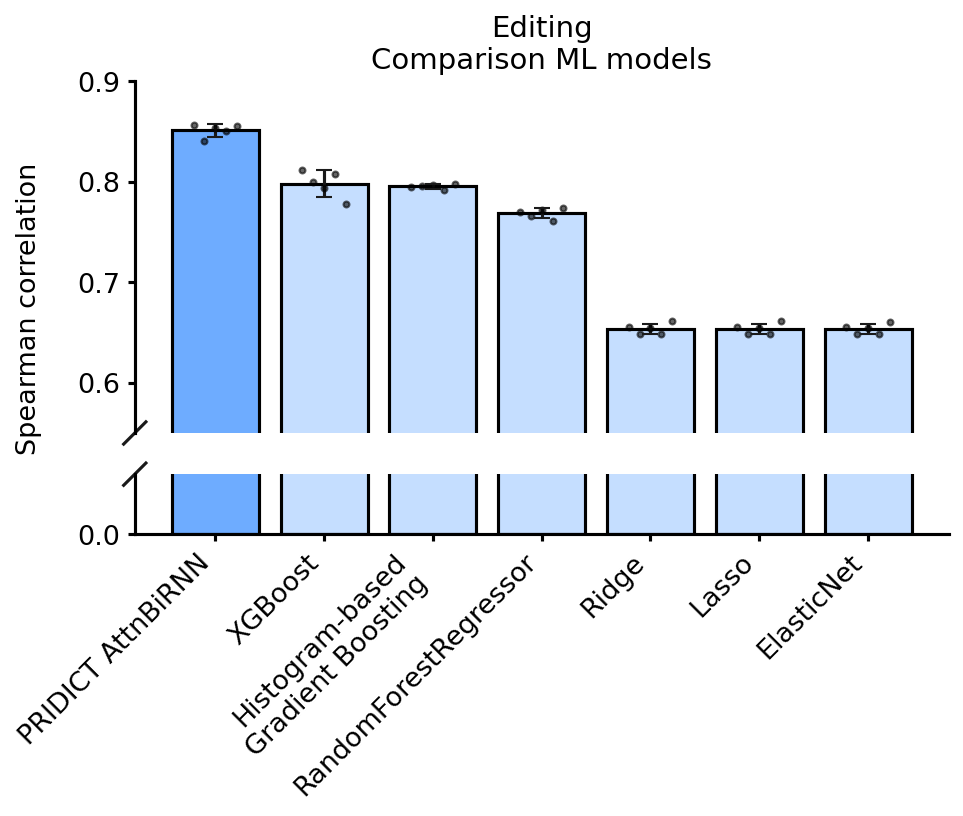

In [370]:

from brokenaxes import brokenaxes

fig = plt.figure(figsize=(7,4),dpi=150)
bax = brokenaxes(ylims=((0, .06), (.55, 0.9)), hspace=.2)

bax.set_title('Editing\nComparison ML models', fontsize=14)
bax.bar(basicmodelsdf['labels'],basicmodelsdf['spearmanscore'], yerr=basicmodelsdf['spearmanstdv'], **bar_kwargs)

x = list(basicmodelsdf['labels'])
y = editing_spearman_individual_run_value_summary
counter = 0
for i in range(len(x)):
    for runnr in range(5):
        bax.scatter(i+(runnr/5-0.4)/2, y[counter], s=8, color='black',edgecolors='face',alpha=0.6,zorder=2)
        counter+=1


bax.axs[-1].set_xticks(range(0,7))
bax.axs[-1].set_xticklabels(basicmodelsdf['labels'], ha="right")
bax.set_ylabel('Spearman correlation\n', fontsize=13)
bax.tick_params(axis='x', labelsize= 13, width=1.5, rotation=45)
bax.tick_params(axis='y', labelsize= 13, width=1.5)
bax.get_children()[0][36].set_facecolor('#6eacff')
bax.get_children()[1][36].set_facecolor('#6eacff') 

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\02_ML_models\\'
plt.savefig(figurepath+'ml_model_comparison_brokenaxis.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

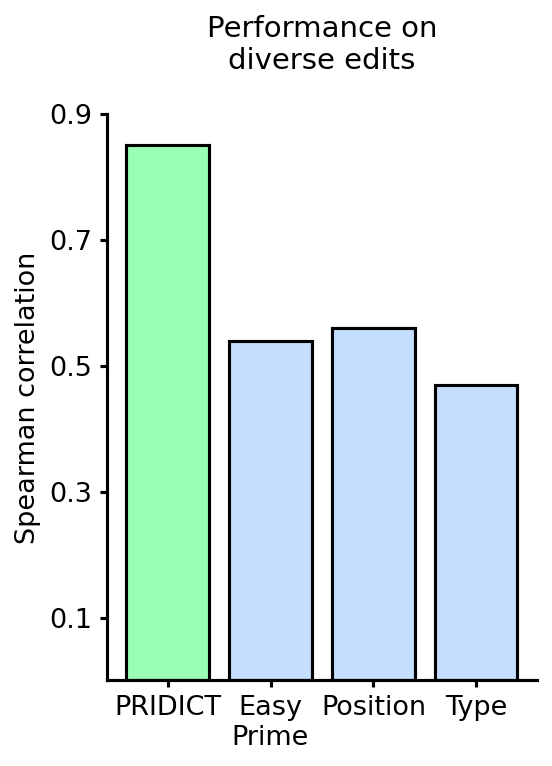

In [371]:
labels = ['PRIDICT','Easy\nPrime','Position','Type']
diverseeditmodelspearman = [averagedeepscore, 0.54, 0.56, 0.47]

fig17, ax17 = plt.subplots(figsize = (3.7, 5),dpi=150)
ax17.set_title('Performance on\ndiverse edits\n', fontsize=14)
ax17.bar(labels, diverseeditmodelspearman, **bar_kwargs)
ax17.set_ylabel('Spearman correlation', fontsize=13)
ax17.spines['right'].set_visible(False)
ax17.spines['top'].set_visible(False)
ax17.get_children()[0].set_facecolor('#9AFFB5')
ax17.set_ylim(0.0,0.9)
ax17.set_yticks(list(np.arange(0.1,1.0,0.2)))
ax17.tick_params(axis='x', labelsize= 13, width=1.5)
ax17.tick_params(axis='y', labelsize= 13, width=1.5)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\04_Validation_Endogenous\\'
plt.savefig(figurepath+'performance_diverse_edits.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


In [372]:
diverseeditmodelspearman

[0.8513599443172097, 0.54, 0.56, 0.47]

## Baselinemodels Unintended edits

In [373]:
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\baseline_evaluation_results_2022-07-21_15-18-07\\randomsearchCV\\baseline_models_averageindel_individual_clamped_res\\"

modelbenchmarkdf = pd.read_csv(path+'baseline_avgruns.csv')
modelbenchmarkdf = modelbenchmarkdf[modelbenchmarkdf['model_name'].str.contains("norm_False")]
modelbenchmarkdf['model_type'] = modelbenchmarkdf['model_name'].apply(lambda x: x[:-12])
modelnames = list(modelbenchmarkdf['model_type'])
modelbenchmarkdf

spearmansummary = list(modelbenchmarkdf['avg_spearman_score'])
spearmansummary.reverse()
spearmanstdv = list(modelbenchmarkdf['spearman_score_std'])
spearmanstdv.reverse()

modelnames[4] = 'Histogram-based\nGradient Boosting'  # add line break for HistGradBoost
modelnames[5] = 'XGBoost'
modelnames.reverse()

path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44\\"

resdf = pd.read_csv(path+'res_df.csv')
deepbenchmarkdf = resdf[resdf['outcome_name'] == 'averageedited']
indelbenchmarkdf = resdf[resdf['outcome_name'] == 'averageindel']
averageindelspearmanscore = indelbenchmarkdf['spearman_score'].mean()
averageindelpearsonscore = indelbenchmarkdf['pear_score'].mean()
averagedeepscore = deepbenchmarkdf['spearman_score'].mean()
deepstdv = indelbenchmarkdf['spearman_score'].std()
spearmansummary.insert(0,averageindelspearmanscore)
spearmanstdv.insert(0,deepstdv)
modelnames.insert(0,'PRIDICT AttnBiRNN')

In [374]:
modelshortnamelist = ['Ridge',
 'Lasso',
 'ElasticNet',
 'RandomForestRegressor',
 'HistGradientBoostingRegressor',
 'xgboost']

def list_files(directory):
    return [f for f in listdir(directory) if 'False_5runs.csv' in f]
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\baseline_evaluation_results_2022-07-21_15-18-07\\randomsearchCV\\baseline_models_averageindel_individual_clamped_res\\"

modellist = list_files(path)
for model in modellist:
    editing_spearman_individual_run_values = []
    indel_spearman_individual_run_values = []
    modelshortname = model.split('_')[0]
    ind = modelbenchmarkdf.index[modelbenchmarkdf['model_type'] == modelshortname].tolist()[0]
    fiverundf = pd.read_csv(path+model)
    for runnr in range(0,5):
        editing_spearman_individual_run_values.append(fiverundf.at[0,'run_'+str(runnr)])
        indel_spearman_individual_run_values.append(fiverundf.at[1,'run_'+str(runnr)])
        modelbenchmarkdf.at[ind,'indel_individual_spearman_run_'+str(runnr)] = fiverundf.at[0,'run_'+str(runnr)]

indelindividualdf = pd.DataFrame()        
modelbenchmarkdf = modelbenchmarkdf.sort_values(by=['avg_spearman_score'],ascending=False)
indel_spearman_individual_run_value_summary = []
namelist = []
for index, row in modelbenchmarkdf.iterrows():
    for runnr in range(0,5):
        indel_spearman_individual_run_value_summary.append(row['indel_individual_spearman_run_'+str(runnr)])
        namelist.append(row['model_type'])
    
pridict_individual_spearman_values = list(indelbenchmarkdf['spearman_score'])

for runnr in range(0,5):
    indel_spearman_individual_run_value_summary.insert(0,pridict_individual_spearman_values[runnr])
    namelist.insert(0,'PRIDICT')
    
indelindividualdf['names'] = namelist
indelindividualdf['indel_spearmanvalues'] = indel_spearman_individual_run_value_summary

In [375]:
modelbenchmarkdf

Unnamed: 0                                 model_name  avg_pear_score  \
11          11                        xgboost=>norm_False        0.632621   
9            9  HistGradientBoostingRegressor=>norm_False        0.630751   
7            7          RandomForestRegressor=>norm_False        0.594782   
1            1                          Ridge=>norm_False        0.563361   
5            5                     ElasticNet=>norm_False        0.563016   
3            3                          Lasso=>norm_False        0.563270   

    pear_score_std  avg_spearman_score  spearman_score_std  \
11        0.013207            0.681481            0.014540   
9         0.015385            0.681370            0.005327   
7         0.015767            0.648612            0.005184   
1         0.010773            0.638511            0.007490   
5         0.010964            0.638481            0.007335   
3         0.010824            0.638328            0.007360   

                       model_type  indel_individual_spearman_run_0  \
11                        xgboost                         0.678204   
9   HistGradientBoostingRegressor                         0.674438   
7           RandomForestRegressor                         0.649659   
1                           Ridge                         0.630958   
5                      ElasticNet                         0.630808   
3                           Lasso                         0.630918   

    indel_individual_spearman_run_1  indel_individual_spearman_run_2  \
11                         0.682487                         0.695681   
9                          0.677441                         0.687511   
7                          0.642876                         0.652255   
1                          0.636841                         0.651063   
5                          0.636341                         0.650674   
3                          0.636324                         0.650674   

    indel_individual_spearman_run_3  indel_individual_spearman_run_4  
11                         0.692265                         0.658766  
9                          0.682970                         0.684492  
7                          0.643672                         0.654597  
1                          0.637697                         0.635994  
5                          0.637650                         0.636931  
3                          0.637589                         0.636137

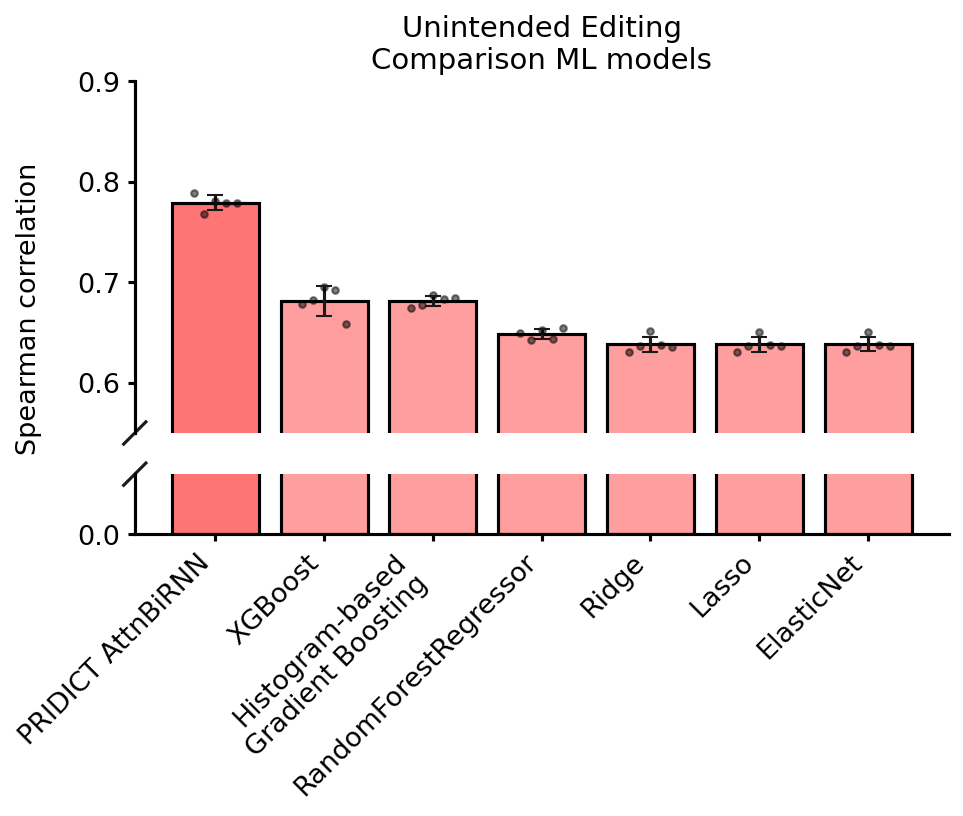

In [376]:
unintbasicmodelsdf = pd.DataFrame()
unintbasicmodelsdf['labels'] = modelnames
unintbasicmodelsdf['spearmanscore'] = spearmansummary
unintbasicmodelsdf['spearmanstdv'] = spearmanstdv
unintbasicmodelsdf = unintbasicmodelsdf.sort_values(by='spearmanscore', ascending=False)
unintbasicmodelsdf = unintbasicmodelsdf.set_index('labels', drop=False)
basicmodelsdf['unintspearmanscore'] = unintbasicmodelsdf['spearmanscore']
basicmodelsdf['unintspearmanstdv'] = unintbasicmodelsdf['spearmanstdv']

from brokenaxes import brokenaxes

fig = plt.figure(figsize=(7,4),dpi=150)
bax = brokenaxes(ylims=((0, .06), (.55, 0.9)), hspace=.2)

bax.set_title('Unintended Editing\nComparison ML models', fontsize=14)
bax.bar(basicmodelsdf['labels'],basicmodelsdf['unintspearmanscore'], yerr=basicmodelsdf['unintspearmanstdv'], **bar_unintended_kwargs)

x = list(unintbasicmodelsdf['labels'])
y = indel_spearman_individual_run_value_summary
counter = 0
for i in range(len(x)):
    for runnr in range(5):
        bax.scatter(i+(runnr/5-0.4)/2, y[counter], s=10, color='black',alpha=0.5,zorder=2)
        counter+=1

bax.axs[-1].set_xticks(range(0,7))
bax.axs[-1].set_xticklabels(basicmodelsdf['labels'], ha="right")
bax.set_ylabel('Spearman correlation\n', fontsize=13)
bax.tick_params(axis='x', labelsize= 13, width=1.5, rotation=45)
bax.tick_params(axis='y', labelsize= 13, width=1.5)
bax.get_children()[0][36].set_facecolor('#ff7575')
bax.get_children()[1][36].set_facecolor('#ff7575') 

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\02_ML_models\\'
plt.savefig(figurepath+'ml_model_unintended_editing_comparison_brokenaxis.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

## RNN Attention model - Test-data - Trained on Schwank

In [377]:
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44"


run2df = pd.read_csv(path+"\\pred_df_20_run2.csv")
truescore = 'true_averageedited'
predscore = 'pred_averageedited'

#convert score to %
run2df[truescore] = run2df[truescore].apply(lambda x: x*100)
run2df[predscore] = run2df[predscore].apply(lambda x: x*100)

#calculate colors for scatterplot (the denser the area, the more yellow it gets)
xy = np.vstack([run2df[predscore],run2df[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = run2df[predscore][idx], run2df[truescore][idx], z[idx]


rnnatt_R = stats.spearmanr(run2df[predscore],run2df[truescore])[0]
rnnatt_r = stats.pearsonr(run2df[predscore],run2df[truescore])[0]

In [378]:
run2df_detailed = pd.read_csv(path+"\\test_df_20_run2.csv")
run2df_detailed = run2df_detailed.set_index('seq_id')

18485


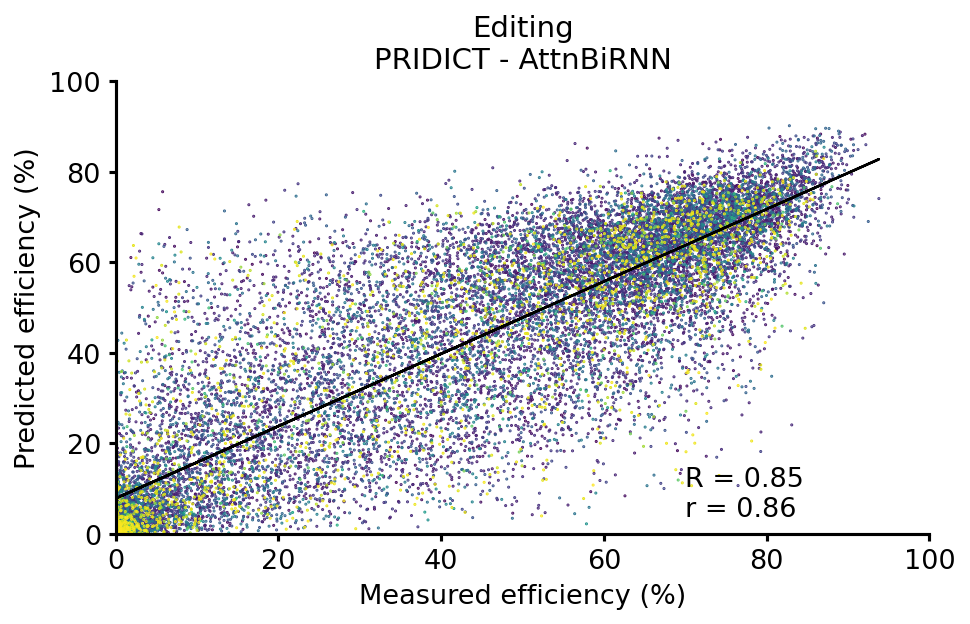

In [379]:
print(len(run2df[truescore]))
fig, ax = plt.subplots(1,1,figsize = (7, 4),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(run2df[truescore],run2df[predscore], c=Correlation_z, s=0.2)
ax.set_title('Editing\nPRIDICT - AttnBiRNN', fontsize=14)
ax.set_xlabel('Measured efficiency (%)', fontsize=13)
ax.set_ylabel('Predicted efficiency (%)', fontsize=13)
ax.tick_params(axis='x', labelsize= 13, width=1.5)
ax.tick_params(axis='y', labelsize= 13, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(run2df[truescore],run2df[predscore], 1)
ax.plot(run2df[truescore], m*run2df[truescore] + b, color='black', linewidth=1.2)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=13,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\02_ML_models\\'
plt.savefig(figurepath+'pridict_schwank_deep_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


## Correlation tested on insertions only

In [335]:
path ="C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44"


truescore = 'true_averageedited'
predscore = 'pred_averageedited'

run2_insertion_df = pd.read_csv(path+"\\pred_df_20_run2.csv")
run2_insertion_df = run2_insertion_df.set_index('seq_id')
run2_insertion_df_detailed = pd.read_csv(path+"\\test_df_20_run2.csv")
run2_insertion_df_detailed = run2_insertion_df_detailed.set_index('seq_id')

#convert score to %
run2_insertion_df[truescore] = run2_insertion_df[truescore].apply(lambda x: x*100)
run2_insertion_df[predscore] = run2_insertion_df[predscore].apply(lambda x: x*100)

run2_insertion_df['Correction_Type'] = run2_insertion_df_detailed['Correction_Type']
run2_insertion_df['RToverhanglength'] = run2_insertion_df_detailed['RToverhanglength']

run2insertiondf = run2_insertion_df[run2_insertion_df['Correction_Type'] == 'Insertion'].copy()
run2deletiondf = run2_insertion_df[run2_insertion_df['Correction_Type'] == 'Deletion'].copy()
run2replacementdf = run2_insertion_df[run2_insertion_df['Correction_Type'] == 'Replacement'].copy()

5596


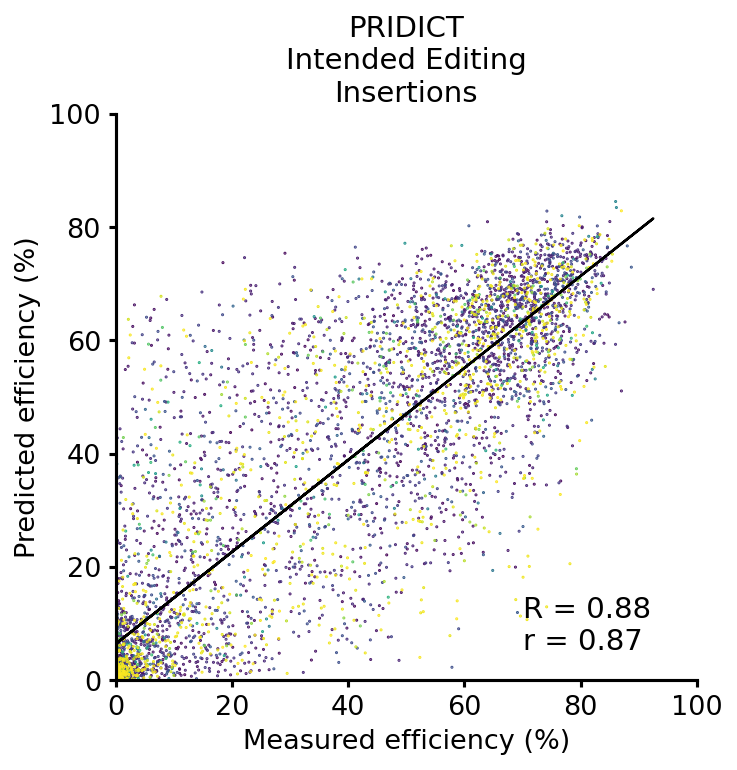

In [336]:


#calculate colors for scatterplot (the denser the area, the more yellow it gets)
xy = np.vstack([run2insertiondf[predscore],run2insertiondf[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = run2insertiondf[predscore][idx], run2insertiondf[truescore][idx], z[idx]

rnnatt_R = stats.spearmanr(run2insertiondf[predscore],run2insertiondf[truescore])[0]
rnnatt_r = stats.pearsonr(run2insertiondf[predscore],run2insertiondf[truescore])[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(run2insertiondf[truescore],run2insertiondf[predscore], c=Correlation_z, s=0.2)
ax.set_title('PRIDICT\nIntended Editing\nInsertions', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(run2insertiondf[truescore],run2insertiondf[predscore], 1)
ax.plot(run2insertiondf[truescore], m*run2insertiondf[truescore] + b, color='black', linewidth=1.2)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'pridict_insertions_schwank_deep_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
print(len(run2insertiondf))

## Correlation tested on deletions only

1295


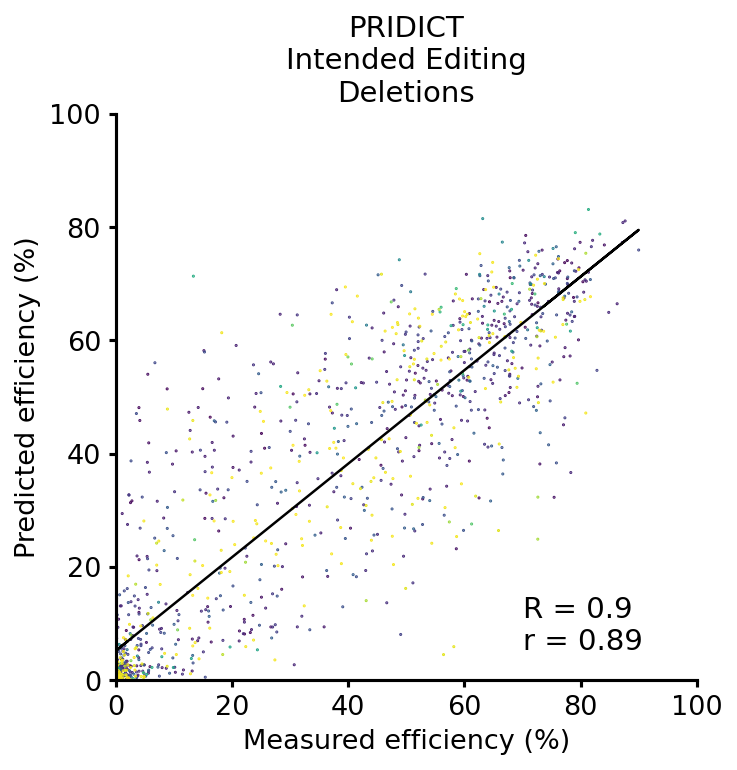

In [337]:
#calculate colors for scatterplot (the denser the area, the more yellow it gets)
xy = np.vstack([run2deletiondf[predscore],run2deletiondf[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = run2deletiondf[predscore][idx], run2deletiondf[truescore][idx], z[idx]

rnnatt_R = stats.spearmanr(run2deletiondf[predscore],run2deletiondf[truescore])[0]
rnnatt_r = stats.pearsonr(run2deletiondf[predscore],run2deletiondf[truescore])[0]

fig, ax = plt.subplots(1,1,figsize = (5, 5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(run2deletiondf[truescore],run2deletiondf[predscore], c=Correlation_z, s=0.2)
ax.set_title('PRIDICT\nIntended Editing\nDeletions', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(run2deletiondf[truescore],run2deletiondf[predscore], 1)
ax.plot(run2deletiondf[truescore], m*run2deletiondf[truescore] + b, color='black', linewidth=1.2)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'pridict_deletions_schwank_deep_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
print(len(run2deletiondf))

## Correlation tested on replacements only

11594


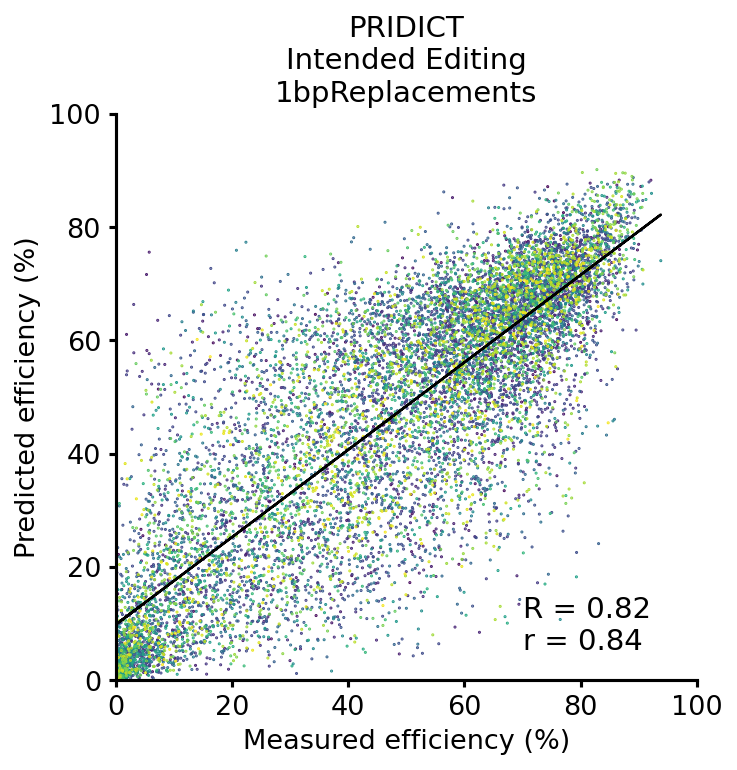

In [338]:
#calculate colors for scatterplot (the denser the area, the more yellow it gets)
xy = np.vstack([run2replacementdf[predscore],run2replacementdf[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = run2replacementdf[predscore][idx], run2replacementdf[truescore][idx], z[idx]

rnnatt_R = stats.spearmanr(run2replacementdf[predscore],run2replacementdf[truescore])[0]
rnnatt_r = stats.pearsonr(run2replacementdf[predscore],run2replacementdf[truescore])[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(run2replacementdf[truescore],run2replacementdf[predscore], c=Correlation_z, s=0.2)
ax.set_title('PRIDICT\nIntended Editing\n1bpReplacements', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(run2replacementdf[truescore],run2replacementdf[predscore], 1)
ax.plot(run2replacementdf[truescore], m*run2replacementdf[truescore] + b, color='black', linewidth=1.2)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'pridict_replacements_schwank_deep_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
print(len(run2replacementdf))

In [339]:
path ="C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44"

truescore = 'true_averageedited'
predscore = 'pred_averageedited'

total_gtoc_df = pd.DataFrame()
allruns = []
for run in range(0,5):
    gtoc_df = pd.read_csv(path+"\\pred_df_20_run"+str(run)+".csv")
    gtoc_df = gtoc_df.set_index('seq_id')
    gtoc_df_detailed = pd.read_csv(path+"\\test_df_20_run"+str(run)+".csv")
    gtoc_df_detailed = gtoc_df_detailed.set_index('seq_id')

    #convert score to %
    gtoc_df[truescore] = gtoc_df[truescore].apply(lambda x: x*100)
    gtoc_df[predscore] = gtoc_df[predscore].apply(lambda x: x*100)

    gtoc_df['Correction_Type'] = gtoc_df_detailed['Correction_Type']
    gtoc_df['RToverhanglength'] = gtoc_df_detailed['RToverhanglength']
    gtoc_df['AlternateAllele'] = gtoc_df_detailed['AlternateAllele']
    gtoc_df['ReferenceAllele'] = gtoc_df_detailed['ReferenceAllele']
    gtoc_df['Editing_Position_Ahmed'] = gtoc_df_detailed['Editing_Position_Ahmed']
    gtoc_df = gtoc_df[(gtoc_df['AlternateAllele'] == "G") & (gtoc_df['ReferenceAllele'] == "C") & (gtoc_df['Editing_Position_Ahmed'] == 30)]
    allruns.append(gtoc_df)
total_gtoc_df = pd.concat(allruns)
gtoc_df = total_gtoc_df

In [340]:
R_list = []
r_list = []
for run in allruns:
    rnnatt_R = stats.spearmanr(run[predscore],run[truescore])[0]
    R_list.append(rnnatt_R)
    rnnatt_r = stats.pearsonr(run[predscore],run[truescore])[0]
    r_list.append(rnnatt_r)

In [341]:
R_average = sum(R_list) / len(R_list)
r_average = sum(r_list) / len(r_list)
print(R_list, r_list)
print(round(R_average,2), round(r_average,2))

[0.7728356591247797, 0.7280436399702456, 0.7458247966722542, 0.848154337381755, 0.8128901044954063] [0.8125423278318809, 0.7281587843350867, 0.7577605745880327, 0.9262878458477762, 0.8195753106136051]
0.78 0.81


540


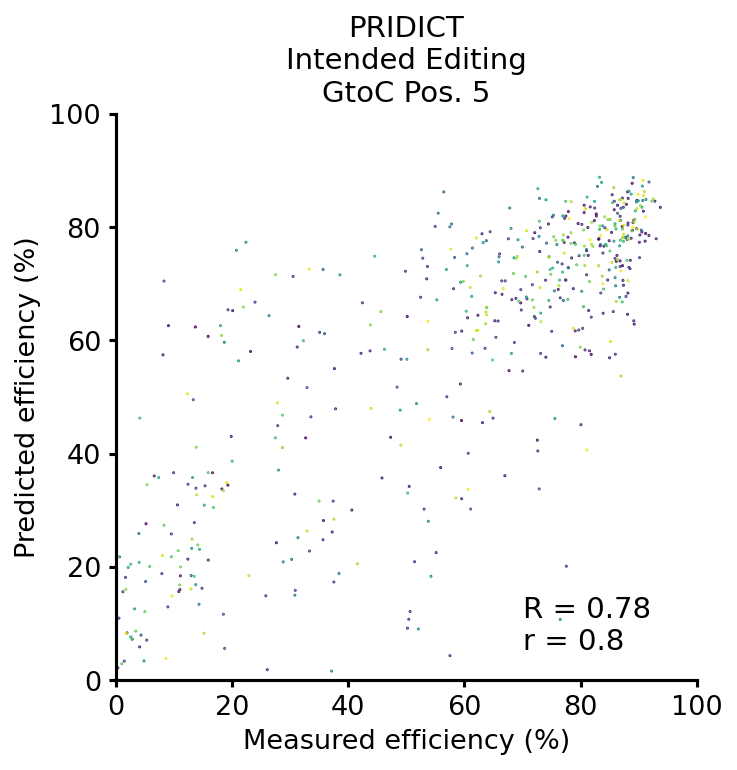

In [342]:
#calculate colors for scatterplot (the denser the area, the more yellow it gets)
xy = np.vstack([gtoc_df[predscore],gtoc_df[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = gtoc_df[predscore][idx], gtoc_df[truescore][idx], z[idx]

rnnatt_R = stats.spearmanr(gtoc_df[predscore],gtoc_df[truescore])[0]
rnnatt_r = stats.pearsonr(gtoc_df[predscore],gtoc_df[truescore])[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(gtoc_df[truescore],gtoc_df[predscore], c=Correlation_z, s=0.2)
ax.set_title('PRIDICT\nIntended Editing\nGtoC Pos. 5', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(gtoc_df[truescore],gtoc_df[predscore], 1)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'pridict_GtoCPos5_allruns_schwank_deep_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
print(len(gtoc_df))

## Correlations on different sub-testsets

In [343]:
path ="C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44"


truescore = 'true_averageedited'
predscore = 'pred_averageedited'

run2df = pd.read_csv(path+"\\pred_df_20_run2.csv")
run2df = run2df.set_index('seq_id')
run2df_detailed = pd.read_csv(path+"\\test_df_20_run2.csv")
run2df_detailed = run2df_detailed.set_index('seq_id')

#convert score to %
run2df[truescore] = run2df[truescore].apply(lambda x: x*100)
run2df[predscore] = run2df[predscore].apply(lambda x: x*100)

run2df['Correction_Type'] = run2df_detailed['Correction_Type']
run2df['RToverhanglength'] = run2df_detailed['RToverhanglength']

run2insertiondf = run2df[run2df['Correction_Type'] == 'Insertion'].copy()
run2deletiondf = run2df[run2df['Correction_Type'] == 'Deletion'].copy()
run2replacementdf = run2df[run2df['Correction_Type'] == 'Replacement'].copy()
run2shortRToverhangdf = run2df[run2df['RToverhanglength'] == 3].copy()
run2longRToverhangdf = run2df[run2df['RToverhanglength'] > 3].copy()


insertion_R = stats.spearmanr(run2insertiondf[predscore],run2insertiondf[truescore])[0]
insertion_r = stats.pearsonr(run2insertiondf[predscore],run2insertiondf[truescore])[0]

deletion_R = stats.spearmanr(run2deletiondf[predscore],run2deletiondf[truescore])[0]
deletion_r = stats.pearsonr(run2deletiondf[predscore],run2deletiondf[truescore])[0]

replacement_R = stats.spearmanr(run2replacementdf[predscore],run2replacementdf[truescore])[0]
replacement_r = stats.pearsonr(run2replacementdf[predscore],run2replacementdf[truescore])[0]

shortRToverhang_R = stats.spearmanr(run2shortRToverhangdf[predscore],run2shortRToverhangdf[truescore])[0]
shortRToverhang_r = stats.pearsonr(run2shortRToverhangdf[predscore],run2shortRToverhangdf[truescore])[0]

longRToverhang_R = stats.spearmanr(run2longRToverhangdf[predscore],run2longRToverhangdf[truescore])[0]
longRToverhang_r = stats.pearsonr(run2longRToverhangdf[predscore],run2longRToverhangdf[truescore])[0]

R_list = [insertion_R, deletion_R, replacement_R, shortRToverhang_R, longRToverhang_R]
r_list = [insertion_r, deletion_r, replacement_r, shortRToverhang_r, longRToverhang_r]

print('R', R_list)
print('r', r_list)

R [0.8779383286722284, 0.8992707480554786, 0.8238506835213814, 0.883209670187259, 0.7982832608937727]
r [0.8712860195776745, 0.8904059893959823, 0.8390847015167215, 0.8476961031513299, 0.8302545857868173]


## Indels - RNN Attention model - Test-data - Trained on Schwank

In [344]:
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44"


truescore = 'true_averageindel'
predscore = 'pred_averageindel'

run2indeldf = pd.read_csv(path+"\\pred_df_20_run2.csv")
testrun2indeldf = pd.read_csv(path+"\\test_df_20_run2.csv")
run2indeldf['Correction_Type'] = testrun2indeldf['Correction_Type']


#convert score to %
run2indeldf[truescore] = run2indeldf[truescore].apply(lambda x: x*100)
run2indeldf[predscore] = run2indeldf[predscore].apply(lambda x: x*100)


#calculate colors for scatterplot (the denser the area, the more yellow it gets)
xy = np.vstack([run2indeldf[predscore],run2indeldf[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = run2indeldf[predscore][idx], run2indeldf[truescore][idx], z[idx]

18485


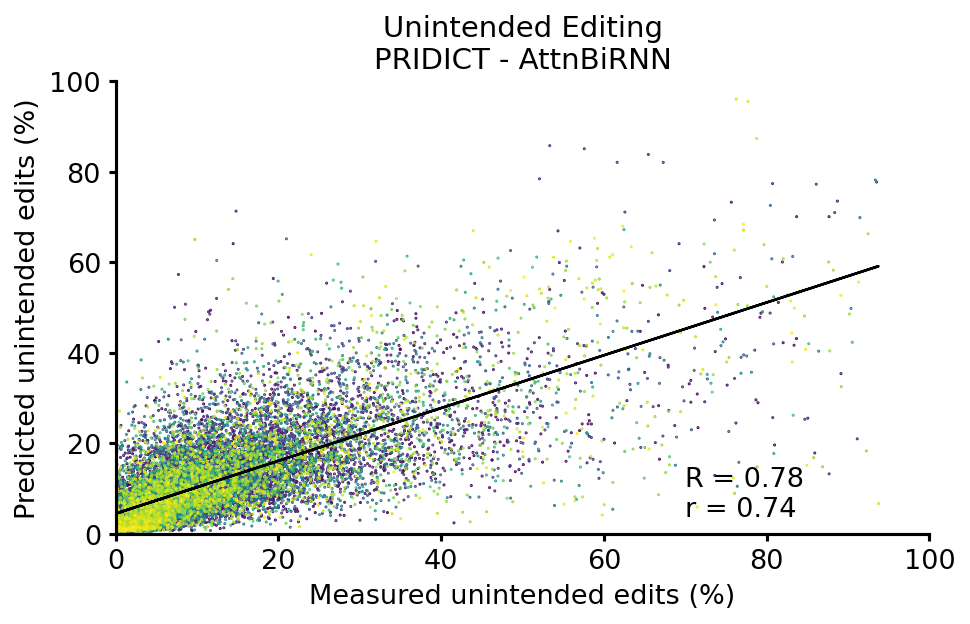

In [236]:
print(len(run2indeldf[truescore]))
rnnatt_R = stats.spearmanr(run2indeldf[predscore],run2indeldf[truescore])[0]
rnnatt_r = stats.pearsonr(run2indeldf[predscore],run2indeldf[truescore])[0]

fig, ax = plt.subplots(1,1,figsize = (7, 4),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(run2indeldf[truescore],run2indeldf[predscore], c=Correlation_z, s=0.2)
ax.set_title('Unintended Editing\nPRIDICT - AttnBiRNN', fontsize=14)
ax.set_xlabel('Measured unintended edits (%)', fontsize=13)
ax.set_ylabel('Predicted unintended edits (%)', fontsize=13)
ax.tick_params(axis='x', labelsize= 13, width=1.5)
ax.tick_params(axis='y', labelsize= 13, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(run2indeldf[truescore],run2indeldf[predscore], 1)
ax.plot(run2indeldf[truescore], m*run2indeldf[truescore] + b, color='black', linewidth=1.2)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=13,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\02_ML_models\\'
plt.savefig(figurepath+'pridict_unintendededits_schwank_deep_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


In [345]:
# path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\models_perf_v2\\neural_models\\exp_2021-09-29_22-14-01\\test\\"

path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44"

truescore = 'true_averageedited'
predscore = 'pred_averageedited'

run2df = pd.read_csv(path+"\\pred_df_20_run2.csv")
run2df = run2df.set_index('seq_id')
run2df_detailed = pd.read_csv(path+"\\test_df_20_run2.csv")
run2df_detailed = run2df_detailed.set_index('seq_id')
run2df_detailed['firsttwobasesafterflap'] = run2df_detailed.apply(lambda x: x.wide_initial_target[int(x['RT_initial_location'][-3:-1]):int(x['RT_initial_location'][-3:-1])+2],axis=1)
run2df_detailed = run2df_detailed[run2df_detailed['firsttwobasesafterflap'] != 'GC']
run2df = run2df.loc[run2df_detailed.index]

#convert score to %
run2df[truescore] = run2df[truescore].apply(lambda x: x*100)
run2df[predscore] = run2df[predscore].apply(lambda x: x*100)

run2df['Correction_Type'] = run2df_detailed['Correction_Type']
run2df['RToverhanglength'] = run2df_detailed['RToverhanglength']

run2insertiondf = run2df[run2df['Correction_Type'] == 'Insertion'].copy()
run2deletiondf = run2df[run2df['Correction_Type'] == 'Deletion'].copy()
run2replacementdf = run2df[run2df['Correction_Type'] == 'Replacement'].copy()
run2shortRToverhangdf = run2df[run2df['RToverhanglength'] == 3].copy()
run2longRToverhangdf = run2df[run2df['RToverhanglength'] > 3].copy()


insertion_R = stats.spearmanr(run2insertiondf[predscore],run2insertiondf[truescore])[0]
insertion_r = stats.pearsonr(run2insertiondf[predscore],run2insertiondf[truescore])[0]

deletion_R = stats.spearmanr(run2deletiondf[predscore],run2deletiondf[truescore])[0]
deletion_r = stats.pearsonr(run2deletiondf[predscore],run2deletiondf[truescore])[0]

replacement_R = stats.spearmanr(run2replacementdf[predscore],run2replacementdf[truescore])[0]
replacement_r = stats.pearsonr(run2replacementdf[predscore],run2replacementdf[truescore])[0]

shortRToverhang_R = stats.spearmanr(run2shortRToverhangdf[predscore],run2shortRToverhangdf[truescore])[0]
shortRToverhang_r = stats.pearsonr(run2shortRToverhangdf[predscore],run2shortRToverhangdf[truescore])[0]

longRToverhang_R = stats.spearmanr(run2longRToverhangdf[predscore],run2longRToverhangdf[truescore])[0]
longRToverhang_r = stats.pearsonr(run2longRToverhangdf[predscore],run2longRToverhangdf[truescore])[0]

R_list = [insertion_R, deletion_R, replacement_R, shortRToverhang_R, longRToverhang_R]
r_list = [insertion_r, deletion_r, replacement_r, shortRToverhang_r, longRToverhang_r]

print('R', R_list)
print('r', r_list)

R [0.8817329630118238, 0.9024119157910646, 0.8261061184835169, 0.8803319052874632, 0.8000413760317777]
r [0.8748684957391253, 0.8902464328915785, 0.8389837128039488, 0.8396284763003612, 0.8308699597218063]


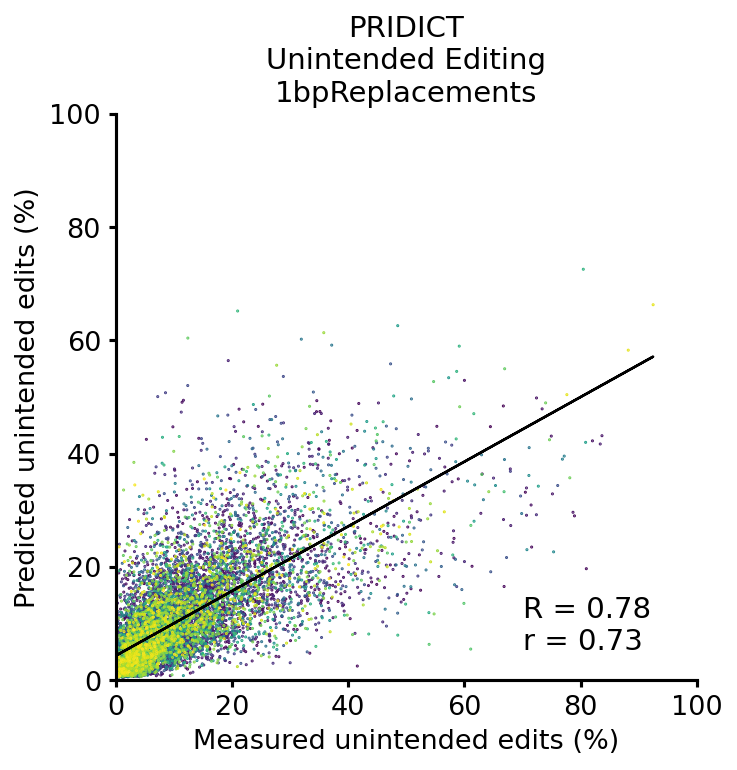

In [346]:
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44"

truescore = 'true_averageindel'
predscore = 'pred_averageindel'

run2indeldf = pd.read_csv(path+"\\pred_df_20_run2.csv")
testrun2indeldf = pd.read_csv(path+"\\test_df_20_run2.csv")
run2indeldf['Correction_Type'] = testrun2indeldf['Correction_Type']

run2indeldf = run2indeldf[run2indeldf['Correction_Type'] == 'Replacement'].reset_index()


#convert score to %
run2indeldf[truescore] = run2indeldf[truescore].apply(lambda x: x*100)
run2indeldf[predscore] = run2indeldf[predscore].apply(lambda x: x*100)


#calculate colors for scatterplot (the denser the area, the more yellow it gets)
xy = np.vstack([run2indeldf[predscore],run2indeldf[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = run2indeldf[predscore][idx], run2indeldf[truescore][idx], z[idx]
rnnatt_R = stats.spearmanr(run2indeldf[predscore],run2indeldf[truescore])[0]
rnnatt_r = stats.pearsonr(run2indeldf[predscore],run2indeldf[truescore])[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(run2indeldf[truescore],run2indeldf[predscore], c=Correlation_z, s=0.2)
ax.set_title('PRIDICT\nUnintended Editing\n1bpReplacements', fontsize=titlesize)
ax.set_xlabel('Measured unintended edits (%)', fontsize=lsize)
ax.set_ylabel('Predicted unintended edits (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(run2indeldf[truescore],run2indeldf[predscore], 1)
ax.plot(run2indeldf[truescore], m*run2indeldf[truescore] + b, color='black', linewidth=1.2)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'pridict_unintended_replacements_schwank_deep_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


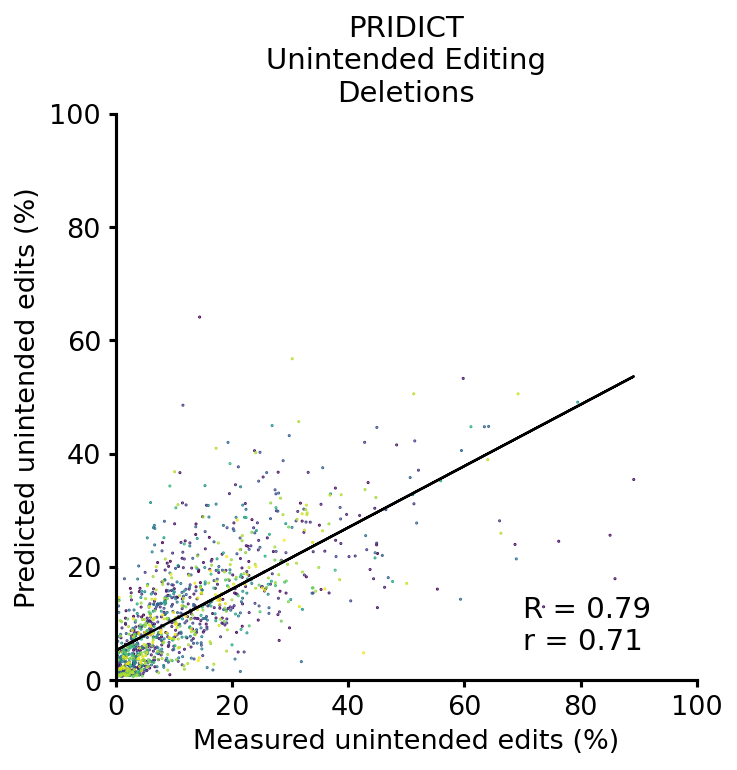

In [347]:
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44"

truescore = 'true_averageindel'
predscore = 'pred_averageindel'

run2indeldf = pd.read_csv(path+"\\pred_df_20_run2.csv")
testrun2indeldf = pd.read_csv(path+"\\test_df_20_run2.csv")
run2indeldf['Correction_Type'] = testrun2indeldf['Correction_Type']

run2indeldf = run2indeldf[run2indeldf['Correction_Type'] == 'Deletion'].reset_index()


#convert score to %
run2indeldf[truescore] = run2indeldf[truescore].apply(lambda x: x*100)
run2indeldf[predscore] = run2indeldf[predscore].apply(lambda x: x*100)


#calculate colors for scatterplot (the denser the area, the more yellow it gets)
xy = np.vstack([run2indeldf[predscore],run2indeldf[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = run2indeldf[predscore][idx], run2indeldf[truescore][idx], z[idx]
rnnatt_R = stats.spearmanr(run2indeldf[predscore],run2indeldf[truescore])[0]
rnnatt_r = stats.pearsonr(run2indeldf[predscore],run2indeldf[truescore])[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(run2indeldf[truescore],run2indeldf[predscore], c=Correlation_z, s=0.2)
ax.set_title('PRIDICT\nUnintended Editing\nDeletions', fontsize=titlesize)
ax.set_xlabel('Measured unintended edits (%)', fontsize=lsize)
ax.set_ylabel('Predicted unintended edits (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(run2indeldf[truescore],run2indeldf[predscore], 1)
ax.plot(run2indeldf[truescore], m*run2indeldf[truescore] + b, color='black', linewidth=1.2)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'pridict_unintended_deletions_schwank_deep_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

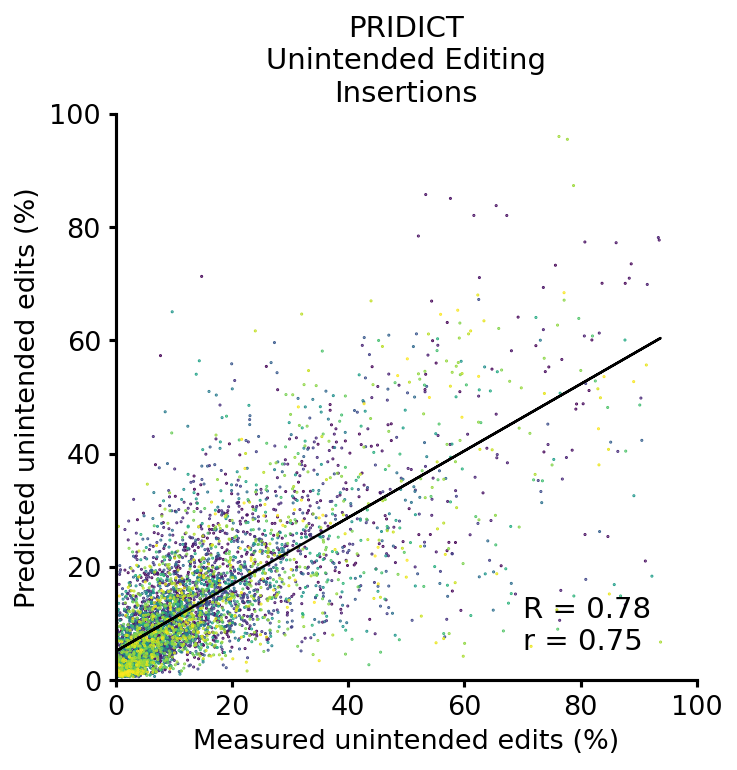

In [348]:
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_schwank\\exp_2022-07-19_18-10-44"

truescore = 'true_averageindel'
predscore = 'pred_averageindel'

run2indeldf = pd.read_csv(path+"\\pred_df_20_run2.csv")
testrun2indeldf = pd.read_csv(path+"\\test_df_20_run2.csv")
run2indeldf['Correction_Type'] = testrun2indeldf['Correction_Type']

run2indeldf = run2indeldf[run2indeldf['Correction_Type'] == 'Insertion'].reset_index()


#convert score to %
run2indeldf[truescore] = run2indeldf[truescore].apply(lambda x: x*100)
run2indeldf[predscore] = run2indeldf[predscore].apply(lambda x: x*100)


#calculate colors for scatterplot (the denser the area, the more yellow it gets)
xy = np.vstack([run2indeldf[predscore],run2indeldf[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = run2indeldf[predscore][idx], run2indeldf[truescore][idx], z[idx]
rnnatt_R = stats.spearmanr(run2indeldf[predscore],run2indeldf[truescore])[0]
rnnatt_r = stats.pearsonr(run2indeldf[predscore],run2indeldf[truescore])[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(run2indeldf[truescore],run2indeldf[predscore], c=Correlation_z, s=0.2)
ax.set_title('PRIDICT\nUnintended Editing\nInsertions', fontsize=titlesize)
ax.set_xlabel('Measured unintended edits (%)', fontsize=lsize)
ax.set_ylabel('Predicted unintended edits (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(run2indeldf[truescore],run2indeldf[predscore], 1)
ax.plot(run2indeldf[truescore], m*run2indeldf[truescore] + b, color='black', linewidth=1.2)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'pridict_unintended_insertions_schwank_deep_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


## RNN Attention model - Trained Schwank tested on Hyongbum

In [349]:

path ="C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_hyongbum\\exp_2022-07-19_18-10-44"

truescore = 'true_averageedited'
predscore = 'pred_averageedited'
preddf = pd.read_csv(path+"\\pred_df_wsize20.csv")
preddf = preddf.set_index('seq_id')
preddf_long = pd.read_csv("C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_hyongbum\\df_test_hyongbum.csv")
preddf_long = preddf_long.set_index('seq_id')
preddf[predscore] = preddf[predscore].apply(lambda x: x*100)
preddf[truescore] = preddf[truescore].apply(lambda x: x*100)
preddf_long[predscore] = preddf[predscore]
preddf_long[truescore] = preddf[truescore]
preddf = preddf_long
hyongbumHTdf = preddf


xy = np.vstack([preddf[predscore],preddf[truescore]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z = preddf[predscore][idx], preddf[truescore][idx], z[idx]

4457


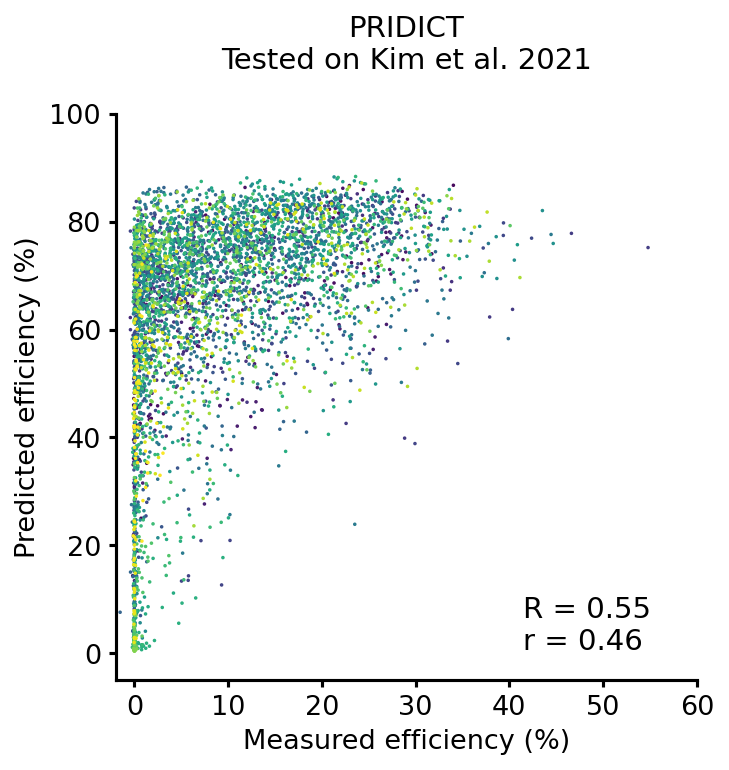

In [350]:
rnnatt_R = stats.spearmanr(preddf[predscore],preddf[truescore])[0]
rnnatt_r = stats.pearsonr(preddf[predscore],preddf[truescore])[0]

print(len(preddf[predscore]))
fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(preddf[truescore],preddf[predscore], c=Correlation_z, s=0.5)
ax.set_title('PRIDICT\nTested on Kim et al. 2021\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(preddf[truescore],preddf[predscore], 1)
ax.set_ylim(-5,100)
ax.set_xlim(-2,60)
ax.text(0.7,0.15, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'TrainSchwank_Test_Hyongbum.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

## Deep model - Trained Hyongbum tested on Schwank (GtoCpos5)

In [351]:
templatedf = pd.read_csv('20220719_templatedf_focused_with_features.csv')

In [353]:
gpos5df = templatedf[(templatedf['AlternateAllele'] == 'G') & (templatedf['ReferenceAllele'] == 'C') & (templatedf['Editing_Position'] == 4)]
print(len(gpos5df))

gpos5df = gpos5df[~(gpos5df['Phenotype'] == 'Control')]
print(len(gpos5df))


GtoC_Hyongbum47bp = gpos5df.apply(lambda x: str(Seq(x.Disease_Block[-25-47:-25]).reverse_complement()), axis=1)
print(len(GtoC_Hyongbum47bp))
GtoC_Hyongbum47bp_df = pd.DataFrame()
GtoC_Hyongbum47bp_df['sequence'] = GtoC_Hyongbum47bp

gpos5df['sequence_47bp'] = GtoC_Hyongbum47bp
GtoC_Hyongbum47bp_df = GtoC_Hyongbum47bp_df.drop_duplicates(subset=['sequence'])
print(len(GtoC_Hyongbum47bp_df))

gpos5df['identifier'] = gpos5df.apply(lambda x: x.sequence_47bp+str(x.PBSlength)+str(x.RTlength), axis=1)
gpos5df = gpos5df.set_index('identifier')
print(len(gpos5df))

hyongbum_prediction = pd.read_csv('20210825_DeepPE_predictions_5GtoC.csv')
hyongbum_prediction['identifier'] = hyongbum_prediction.apply(lambda x: x.sequence+str(x.pbslength)+str(x.rtlength), axis=1)
hyongbum_prediction= hyongbum_prediction.set_index('identifier')
gpos5df['DeepPE_score'] = hyongbum_prediction['edit_rates']
print(len(gpos5df))
gpos5df = gpos5df.dropna(subset=['DeepPE_score'])
print(len(gpos5df))

540
540
540
147
540
540
540


In [354]:
gpos5dfonlylong = gpos5df[gpos5df['RToverhanglength'] > 3].copy()

In [355]:
xy = np.vstack([gpos5dfonlylong['DeepPE_score'],gpos5dfonlylong['averageedited_individual']])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z_Hyongbum = gpos5dfonlylong['DeepPE_score'][idx], gpos5dfonlylong['averageedited_individual'][idx], z[idx]

Text(0.7, 0.95, 'R = 0.32\nr = 0.31')

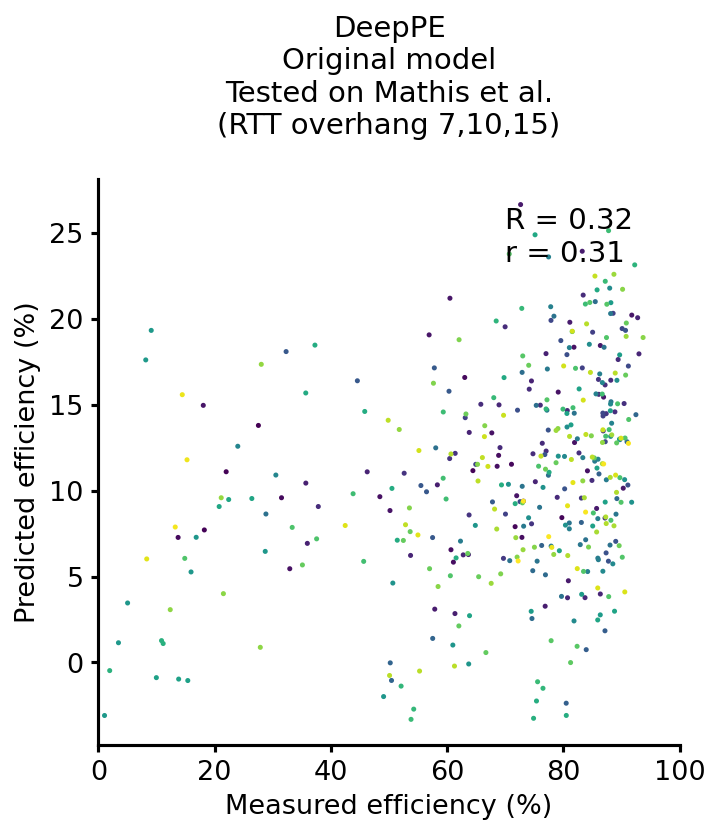

In [357]:
rnnatt_R = stats.spearmanr(gpos5dfonlylong['DeepPE_score'],gpos5dfonlylong['averageedited_individual'])[0]
rnnatt_r = stats.pearsonr(gpos5dfonlylong['DeepPE_score'],gpos5dfonlylong['averageedited_individual'])[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(gpos5dfonlylong['averageedited_individual'],gpos5dfonlylong['DeepPE_score'], c=Correlation_z_Hyongbum, s=2)
ax.set_title('DeepPE\nOriginal model\nTested on Mathis et al.\n(RTT overhang 7,10,15)\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(gpos5dfonlylong['averageedited_individual'],gpos5dfonlylong['DeepPE_score'], 1)

ax.set_xlim(0,100)
ax.text(0.7,0.95, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

In [358]:
xy = np.vstack([gpos5df['DeepPE_score'],gpos5df['averageedited_individual']])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z_Hyongbum = gpos5df['DeepPE_score'][idx], gpos5df['averageedited_individual'][idx], z[idx]

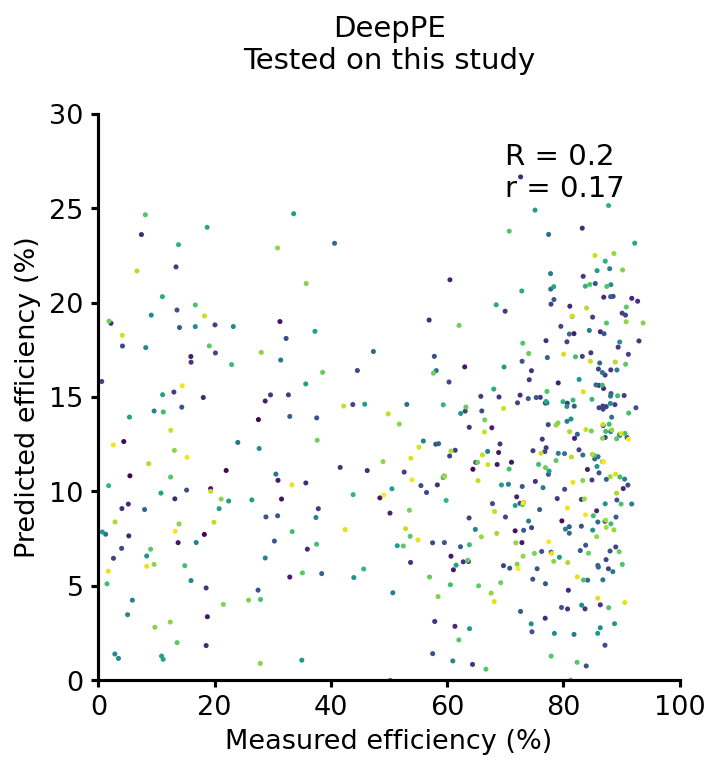

In [359]:
rnnatt_R = stats.spearmanr(gpos5df['DeepPE_score'],gpos5df['averageedited_individual'])[0]
rnnatt_r = stats.pearsonr(gpos5df['DeepPE_score'],gpos5df['averageedited_individual'])[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(gpos5df['averageedited_individual'],gpos5df['DeepPE_score'], c=Correlation_z_Hyongbum, s=2)
ax.set_title('DeepPE\nTested on this study\n', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m, b = np.polyfit(gpos5df['averageedited_individual'],gpos5df['DeepPE_score'], 1)

ax.set_ylim(0,30)
ax.set_xlim(0,100)
ax.text(0.7,0.95, 'R = '+str(round(rnnatt_R,2))+'\nr = '+str(round(rnnatt_r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'TrainHyongbum_Test_Schwank.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [360]:
len(gpos5df)

540

## Endogenous edits in HEK293T

In [380]:
truescore = 'true_averageedited'
predscore = 'pred_averageedited'

aapath = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_endogseqs_withindel\\exp_2022-07-19_18-10-44\\"

endopath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\05_Validations\\02_Arrayed\\Sequencing\\NGS\\'
endogenousHEKdf = pd.read_csv(endopath+'20220719_Editing_Endogenous_HEK293T_deep_new.csv')

ahmedpredictionendogenous = pd.read_csv(aapath+'pred_df_wsize20.csv')

#sort dataframe for sequence number
ahmedpredictionendogenous['new_seq_id'] = ahmedpredictionendogenous['seq_id'].apply(lambda x: int(x.split('_')[1]))
ahmedpredictionendogenous = ahmedpredictionendogenous.sort_values(by=['new_seq_id'])
ahmedpredictionendogenous = ahmedpredictionendogenous.reset_index()
endogenousHEKdf = endogenousHEKdf.reset_index()
ahmedpredictionendogenous[truescore] = endogenousHEKdf['average_between_bio_replicates']
ahmedpredictionendogenous[predscore] = ahmedpredictionendogenous[predscore].apply(lambda x: x*100)
ahmedpredictionendogenous['pred_averageindel'] = ahmedpredictionendogenous['pred_averageindel'].apply(lambda x: x*100)
ahmedpredictionendogenous[truescore] = ahmedpredictionendogenous[truescore].apply(lambda x: 0 if x < 0 else x)

In [381]:
endogenouscontextdf = pd.read_csv("C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_endogseqs_withindel\\df_endogseqs.csv")
endogenouscontextdf = endogenouscontextdf.set_index('seq_id')

for index, row in ahmedpredictionendogenous.iterrows():
    ahmedpredictionendogenous.at[index, 'name'] = endogenouscontextdf.at[row.seq_id,'name.1']

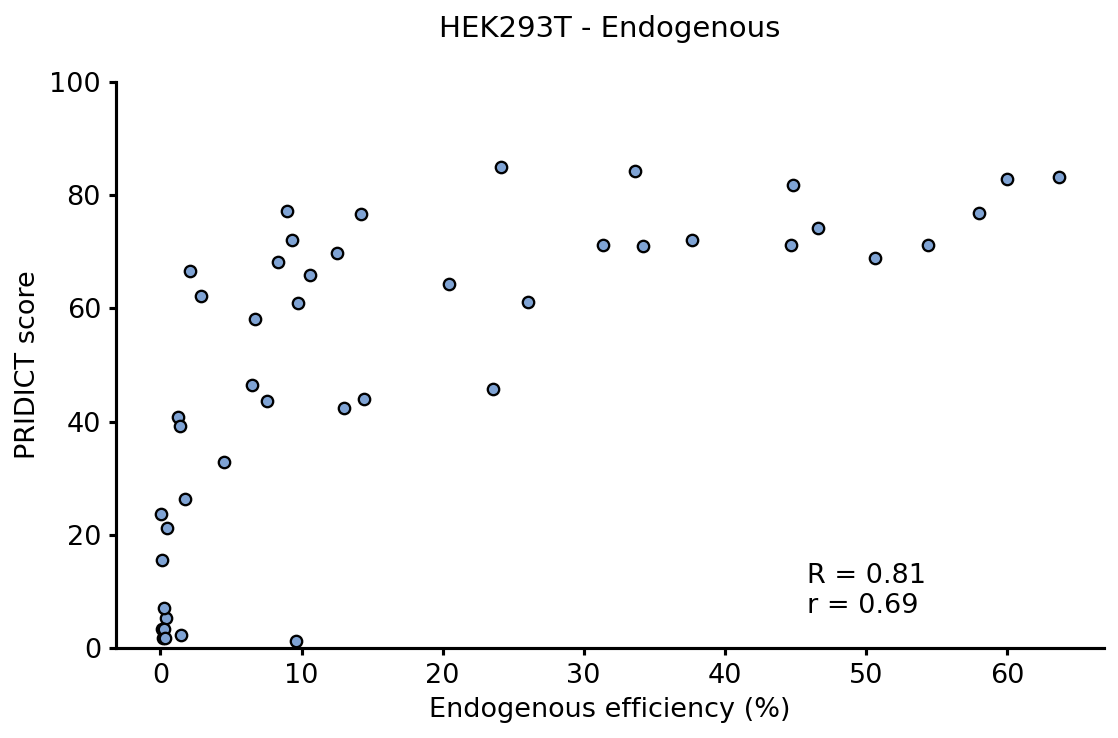

In [382]:
endovspridict_R = stats.spearmanr(ahmedpredictionendogenous[truescore],ahmedpredictionendogenous[predscore])[0]
endovspridict_r = stats.pearsonr(ahmedpredictionendogenous[truescore],ahmedpredictionendogenous[predscore])[0]

fig2, ax2 = plt.subplots(figsize=(8.5,5),dpi=150)
ax2.scatter(ahmedpredictionendogenous[truescore],ahmedpredictionendogenous[predscore], c='#7fa3d4',s=30,edgecolor='black',linewidths=1.1)

ax2.set_title('HEK293T - Endogenous\n', fontsize=14)
ax2.set_xlabel('Endogenous efficiency (%)', fontsize=13)
ax2.set_ylabel('PRIDICT score', fontsize=13)
ax2.tick_params(axis='x', labelsize= 13, width=1.5)
ax2.tick_params(axis='y', labelsize= 13, width=1.5)
m, b = np.polyfit(ahmedpredictionendogenous[truescore],ahmedpredictionendogenous[predscore], 1)

ax2.set_ylim(0,100)

ax2.text(0.7,0.15, 'R = '+str(round(endovspridict_R, 2))+'\nr = '+str(round(endovspridict_r, 2)), transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\04_Validation_Endogenous\\'
plt.savefig(figurepath+'HEK293T_endogenous_editing.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

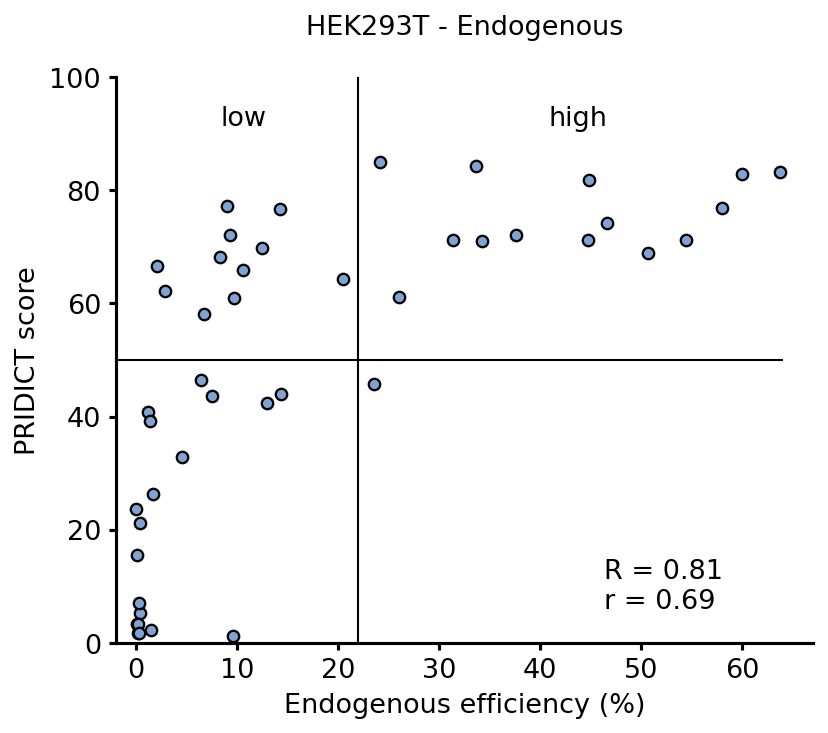

In [383]:
# Same chart but with sections for chromatin comparison

endovspridict_R = stats.spearmanr(ahmedpredictionendogenous[truescore],ahmedpredictionendogenous[predscore])[0]
endovspridict_r = stats.pearsonr(ahmedpredictionendogenous[truescore],ahmedpredictionendogenous[predscore])[0]

fig2, ax2 = plt.subplots(figsize=(6,5),dpi=150)
ax2.scatter(ahmedpredictionendogenous[truescore],ahmedpredictionendogenous[predscore], c='#7fa3d4',s=30,edgecolor='black',linewidths=1.1)

ax2.set_title('HEK293T - Endogenous\n', fontsize=13)
ax2.set_xlabel('Endogenous efficiency (%)', fontsize=13)
ax2.set_ylabel('PRIDICT score', fontsize=13)
ax2.tick_params(axis='x', labelsize= 13, width=1.5)
ax2.tick_params(axis='y', labelsize= 13, width=1.5)
m, b = np.polyfit(ahmedpredictionendogenous[truescore],ahmedpredictionendogenous[predscore], 1)

ax2.set_ylim(0,100)
ax2.set_xlim(-2,67)
ax2.vlines(22,0,100,color='black',linewidth=1)
ax2.hlines(50,-2,64,color='black',linewidth=1)

ax2.text(0.7,0.15, 'R = '+str(round(endovspridict_R, 2))+'\nr = '+str(round(endovspridict_r, 2)), transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')

ax2.text(0.15,0.95, 'low', transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')
ax2.text(0.62,0.95, 'high', transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'HEK293T_endogenous_editing_with_cutoff.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [384]:
endogenousHEKdf['target'] = endogenousHEKdf['Unnamed: 0'].apply(lambda x: x[:2])


In [385]:
averagepridictscorelist = []
averageeditingscorelist = []
for index, row in endogenousHEKdf.iterrows():
    averagepridictscore = endogenousHEKdf[endogenousHEKdf['locus'] == row.locus]['PRIDICT_Score'].mean()
    averageeditingscore = endogenousHEKdf[endogenousHEKdf['locus'] == row.locus]['average_between_bio_replicates'].mean()

    averagepridictscorelist.append(averagepridictscore)
    averageeditingscorelist.append(averageeditingscore)

endogenousHEKdf['averagepridictscore'] = averagepridictscorelist
endogenousHEKdf['averageeditingscore'] = averageeditingscorelist

endovspridict_R = stats.spearmanr(endogenousHEKdf['averageeditingscore'],endogenousHEKdf['averagepridictscore'])[0]
endovspridict_R

0.5571428571428572

In [386]:
lowhekendogenous = ahmedpredictionendogenous[ahmedpredictionendogenous['pred_averageedited'] <50].copy()
highhekendogenous = ahmedpredictionendogenous[ahmedpredictionendogenous['pred_averageedited'] >50].copy()
print(len(lowhekendogenous),len(highhekendogenous))

20 25


In [387]:
lowhekendogenous_R = stats.spearmanr(lowhekendogenous[truescore],lowhekendogenous[predscore])[0]
highhekendogenous_R = stats.spearmanr(highhekendogenous[truescore],highhekendogenous[predscore])[0]

lowhekendogenous_r = stats.pearsonr(lowhekendogenous[truescore],lowhekendogenous[predscore])[0]
highhekendogenous_r = stats.pearsonr(highhekendogenous[truescore],highhekendogenous[predscore])[0]

binned_R = [lowhekendogenous_R,highhekendogenous_R]
binned_r = [lowhekendogenous_r,highhekendogenous_r]
print(lowhekendogenous_R,highhekendogenous_R)

0.5684210526315789 0.5476923076923077


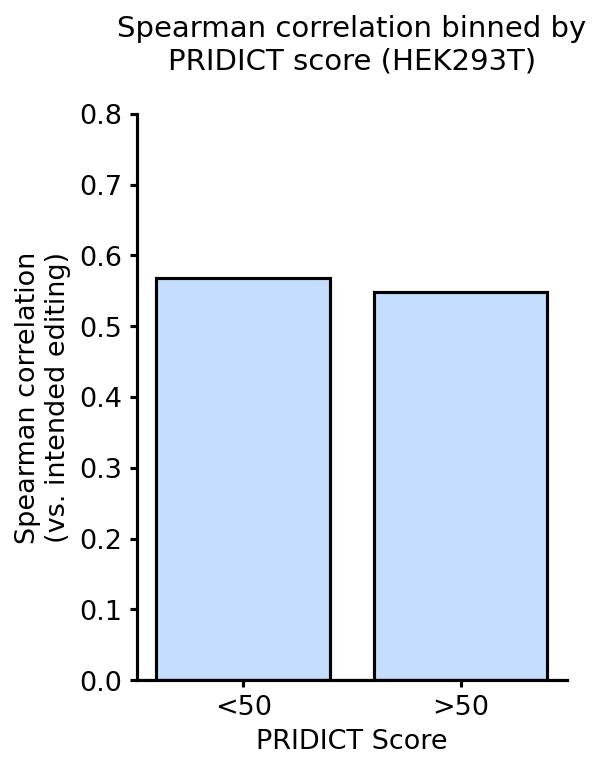

In [388]:
labels = ['<50','>50']

fig17, ax17 = plt.subplots(figsize = (3.7, 5),dpi=150)
ax17.set_title('Spearman correlation binned by\nPRIDICT score (HEK293T)\n', fontsize=titlesize)
ax17.bar(labels, binned_R, **bar_kwargs)
ax17.set_ylabel('Spearman correlation\n(vs. intended editing)', fontsize=lsize)
ax17.set_xlabel('PRIDICT Score', fontsize=lsize)
ax17.spines['right'].set_visible(False)
ax17.spines['top'].set_visible(False)
ax17.set_ylim(0,0.8)
ax17.tick_params(axis='x', labelsize= lsize, width=1.5)
ax17.tick_params(axis='y', labelsize= lsize, width=1.5)
ax17.axhline(0, color = 'black')

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'HEK293T_endoefficiency_PRIDICT_BinnedSpearman.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

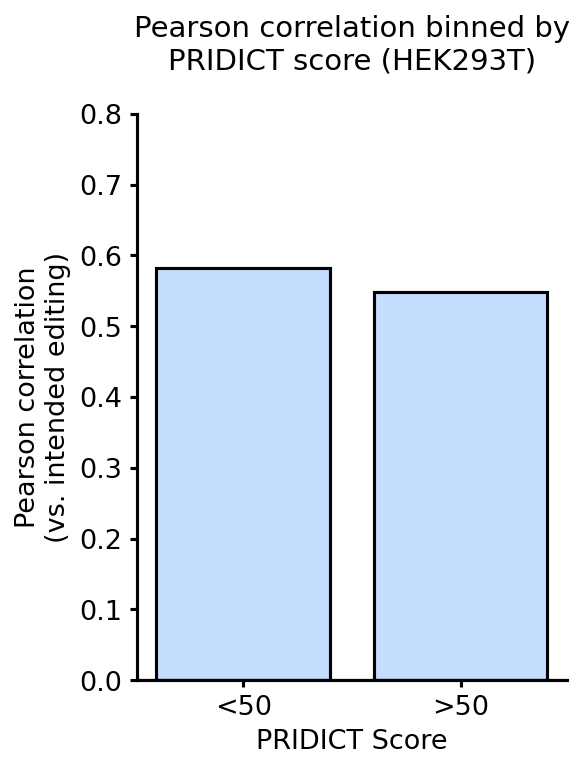

In [389]:
labels = ['<50','>50']

fig17, ax17 = plt.subplots(figsize = (3.7, 5),dpi=150)
ax17.set_title('Pearson correlation binned by\nPRIDICT score (HEK293T)\n', fontsize=titlesize)
ax17.bar(labels, binned_r, **bar_kwargs)
ax17.set_ylabel('Pearson correlation\n(vs. intended editing)', fontsize=lsize)
ax17.set_xlabel('PRIDICT Score', fontsize=lsize)
ax17.spines['right'].set_visible(False)
ax17.spines['top'].set_visible(False)
ax17.set_ylim(0,0.8)
ax17.tick_params(axis='x', labelsize= lsize, width=1.5)
ax17.tick_params(axis='y', labelsize= lsize, width=1.5)
ax17.axhline(0, color = 'black')

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'HEK293T_endoefficiency_PRIDICT_BinnedPearson.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

## Endogenous unintended edits - HEK293T

In [390]:
truescore_indel_HEK = 'true_HEK293T_averageindel'
predscore_indel = 'pred_averageindel'

ahmedpredictionendogenous[truescore_indel_HEK] = endogenousHEKdf['average_indel_between_bio_replicates']

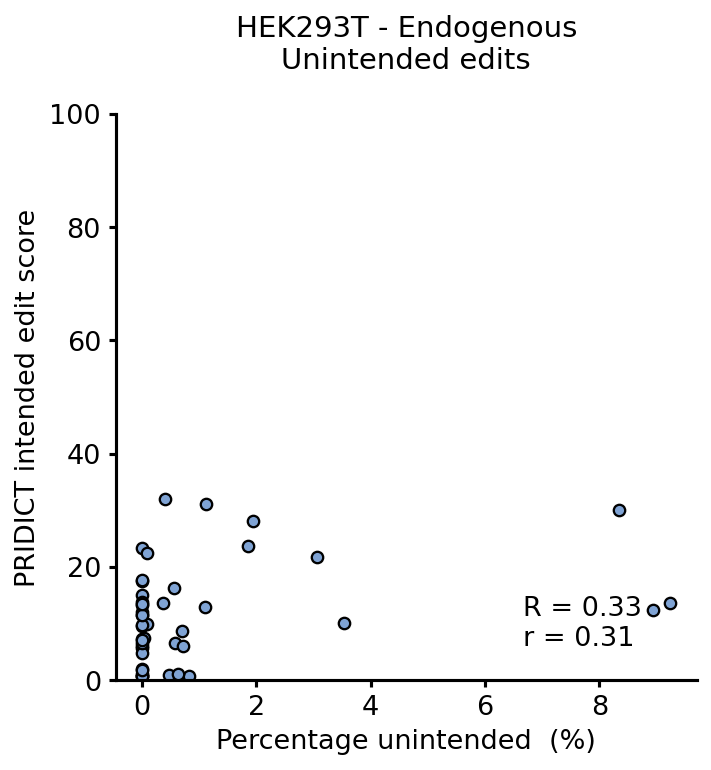

In [391]:
endovspridict_R = stats.spearmanr(ahmedpredictionendogenous[truescore_indel_HEK],ahmedpredictionendogenous[predscore_indel])[0]
HEKendoindel_R = endovspridict_R
endovspridict_r = stats.pearsonr(ahmedpredictionendogenous[truescore_indel_HEK],ahmedpredictionendogenous[predscore_indel])[0]

fig2, ax2 = plt.subplots(figsize=(5,5),dpi=150)
ax2.scatter(ahmedpredictionendogenous[truescore_indel_HEK],ahmedpredictionendogenous[predscore_indel], c='#7fa3d4',s=30,edgecolor='black',linewidths=1.1)

ax2.set_title('HEK293T - Endogenous\nUnintended edits\n', fontsize=14)
ax2.set_xlabel('Percentage unintended  (%)', fontsize=13)
ax2.set_ylabel('PRIDICT intended edit score', fontsize=13)
ax2.tick_params(axis='x', labelsize= 13, width=1.5)
ax2.tick_params(axis='y', labelsize= 13, width=1.5)
m, b = np.polyfit(ahmedpredictionendogenous[truescore_indel_HEK],ahmedpredictionendogenous[predscore_indel], 1)
ax2.set_ylim(0,100)

ax2.text(0.7,0.15, 'R = '+str(round(endovspridict_R, 2))+'\nr = '+str(round(endovspridict_r, 2)), transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


## K562 Validation

In [392]:
path = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\05_Validations\\02_Arrayed\\Sequencing\\NGS\\'
endogenousK562df = pd.read_csv(path+'20220719_Editing_Endogenous_K562_deep_new.csv')
endogenousK562df['average_between_bio_replicates'] = endogenousK562df['average_between_bio_replicates'].apply(lambda x: 0 if x < 0 else x)
ahmedpredictionendogenous['K562_truescore'] = endogenousK562df['average_between_bio_replicates']
ahmedpredictionendogenous['K562_unintended_truescore'] = endogenousK562df['average_indel_between_bio_replicates']

In [393]:
ahmedpredictionendogenous['K562_diff_editing_true_pred'] = ahmedpredictionendogenous['K562_truescore'] -  ahmedpredictionendogenous['pred_averageedited']
highpredictloweditedendogenous = ahmedpredictionendogenous[ahmedpredictionendogenous['pred_averageedited'] > 60].copy()
highpredictloweditedendogenous = highpredictloweditedendogenous[highpredictloweditedendogenous['K562_truescore'] < 5].copy()
highpredictloweditedendogenous

index  seq_id  true_averageedited  true_averageindel  pred_averageedited  \
0       0   seq_0           12.487764           0.092436           69.702113   
12      4  seq_12           31.397644           0.000000           71.162249   
13      5  seq_13            9.324157           0.000000           72.092640   
20     13  seq_20           20.488797           0.000000           64.325695   
25     18  seq_25            2.061006           0.035302           66.585052   
26     19  seq_26            2.879718           0.089446           62.243700   
33     27  seq_33            8.343288           0.000000           68.169972   
37     31  seq_37           14.222314           0.000007           76.728849   
39     33  seq_39            9.738221           0.003706           60.873929   
42     37  seq_42           63.683304           0.000000           83.131394   
43     38  seq_43           10.601202           0.000000           65.915275   

    pred_averageunedited  pred_averageindel  new_seq_id                 name  \
0               0.167447          13.553164           0         01libbestpeg   
12              0.216443           7.193429          12         09libbestpeg   
13              0.183314           9.575996          13         09libendopeg   
20              0.124311          23.243252          20        20libworstpeg   
25              0.233723          10.042621          25         28libendopeg   
26              0.253505          12.405841          26        28libworstpeg   
33              0.198933          11.936730          33   EMX12b10libbestpeg   
37              0.118581          11.413095          37  FANCF2b10libendopeg   
39              0.255278          13.598280          39   HEK32b20libbestpeg   
42              0.150600           1.808600          42   RNF22b14libbestpeg   
43              0.270699           7.014844          43   RNF22b14libendopeg   

    true_HEK293T_averageindel  K562_truescore  K562_unintended_truescore  \
0                    9.243645        2.002138                   0.000000   
12                   0.000000        4.624867                   0.000000   
13                   0.000000        2.217711                   0.054372   
20                   0.000000        1.745185                   0.484325   
25                   3.530175        0.496501                   0.520660   
26                   8.944630        1.358959                   2.478454   
33                   0.000000        0.050259                   0.780117   
37                   0.000713        2.197590                   1.305511   
39                   0.370649        0.232774                   0.000000   
42                   0.000000        2.664535                   0.000000   
43                   0.000000        3.422262                   0.130327   

    K562_diff_editing_true_pred  
0                    -67.699975  
12                   -66.537382  
13                   -69.874929  
20                   -62.580510  
25                   -66.088551  
26                   -60.884741  
33                   -68.119713  
37                   -74.531259  
39                   -60.641156  
42                   -80.466860  
43                   -62.493013

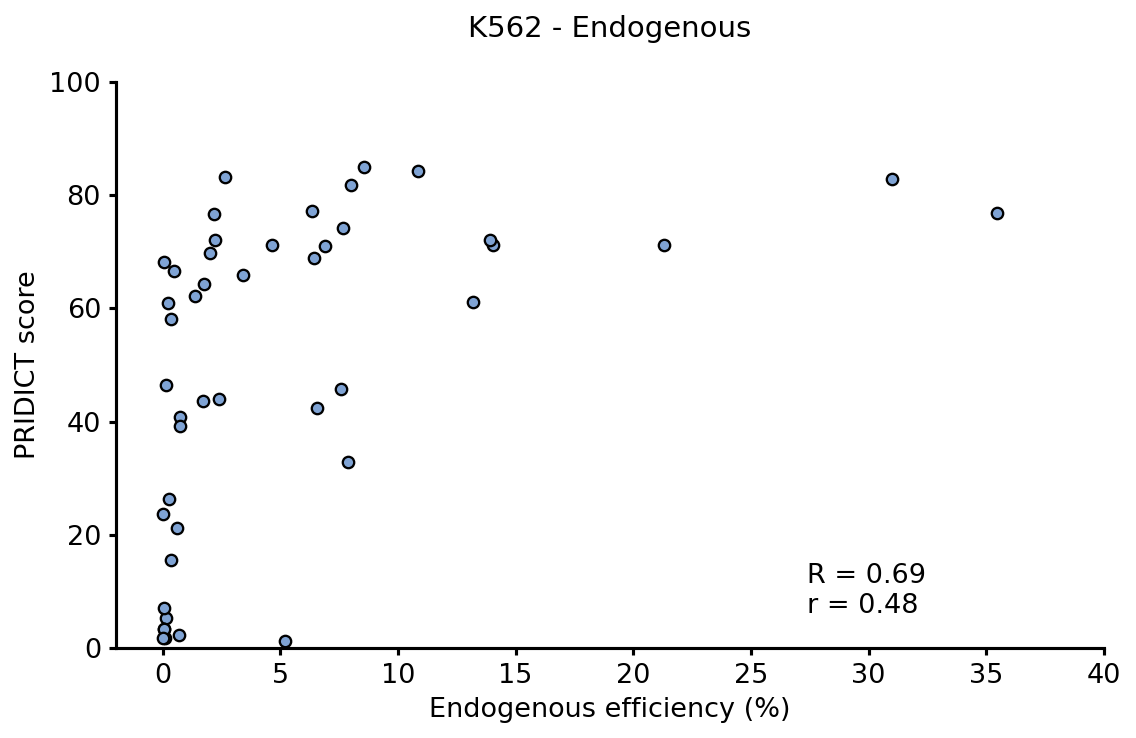

In [394]:
endovspridict_R = stats.spearmanr(endogenousK562df['average_between_bio_replicates'],ahmedpredictionendogenous[predscore])[0]
endovspridict_r = stats.pearsonr(endogenousK562df['average_between_bio_replicates'],ahmedpredictionendogenous[predscore])[0]

uniquelocuslist = endogenousK562df['locus'].unique()

colorlist = ['azure','azure','azure','beige','black','blue','brown','chartreuse','chocolate',
             'coral','crimson','gold','darkblue','pink','fuchsia']
#fig2, ax2 = plt.subplots(figsize=(8.5,5),dpi=150)
fig2, ax2 = plt.subplots(figsize=(8.5,5),dpi=150)
ax2.scatter(endogenousK562df['average_between_bio_replicates'],ahmedpredictionendogenous[predscore], c='#7fa3d4',s=30,edgecolor='black',linewidths=1.1)
# ax2.scatter(summarydf['average_between_bio_replicates'],summarydf['PRIDICT_Score'])
ax2.set_title('K562 - Endogenous\n', fontsize=14)
ax2.set_xlabel('Endogenous efficiency (%)', fontsize=13)
ax2.set_ylabel('PRIDICT score', fontsize=13)
ax2.tick_params(axis='x', labelsize= 13, width=1.5)
ax2.tick_params(axis='y', labelsize= 13, width=1.5)
m, b = np.polyfit(endogenousK562df['average_between_bio_replicates'],ahmedpredictionendogenous[predscore], 1)
#ax2.plot(endogenousK562df['average_between_bio_replicates'], m*endogenousK562df['average_between_bio_replicates'] + b, color='black')
#ax2.plot(endogenousHEKdf['average_between_bio_replicates'], 3.5*endogenousHEKdf['average_between_bio_replicates'] + 35, color = 'black')

ax2.set_ylim(0,100)
ax2.set_xlim(-2,40)
ax2.text(0.7,0.15, 'R = '+str(round(endovspridict_R, 2))+'\nr = '+str(round(endovspridict_r, 2)), transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\04_Validation_Endogenous\\'
plt.savefig(figurepath+'K562_endogenous_editing.pdf', format='pdf',
        transparent=True,bbox_inches='tight')



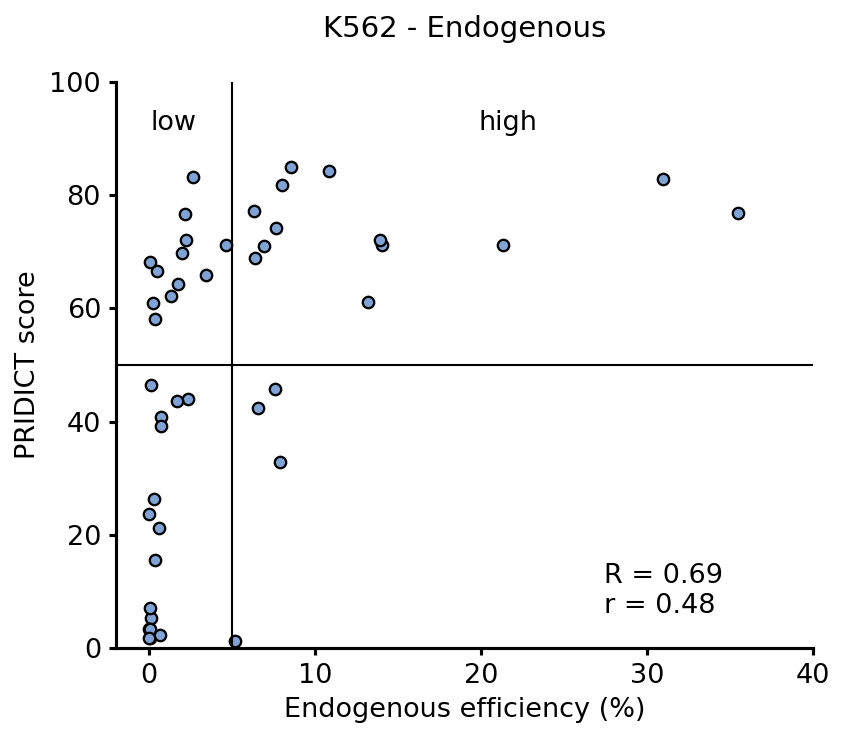

In [395]:
# Same chart but with sections for chromatin comparison

endovspridict_R = stats.spearmanr(endogenousK562df['average_between_bio_replicates'],ahmedpredictionendogenous[predscore])[0]
endovspridict_r = stats.pearsonr(endogenousK562df['average_between_bio_replicates'],ahmedpredictionendogenous[predscore])[0]

uniquelocuslist = endogenousK562df['locus'].unique()

colorlist = ['azure','azure','azure','beige','black','blue','brown','chartreuse','chocolate',
             'coral','crimson','gold','darkblue','pink','fuchsia']
fig2, ax2 = plt.subplots(figsize=(6,5),dpi=150)
ax2.scatter(endogenousK562df['average_between_bio_replicates'],ahmedpredictionendogenous[predscore], c='#7fa3d4',s=30,edgecolor='black',linewidths=1.1)
ax2.set_title('K562 - Endogenous\n', fontsize=14)
ax2.set_xlabel('Endogenous efficiency (%)', fontsize=13)
ax2.set_ylabel('PRIDICT score', fontsize=13)
ax2.tick_params(axis='x', labelsize= 13, width=1.5)
ax2.tick_params(axis='y', labelsize= 13, width=1.5)
m, b = np.polyfit(endogenousK562df['average_between_bio_replicates'],ahmedpredictionendogenous[predscore], 1)
ax2.plot(5, color = 'black')
ax2.hlines(50,-2,40,color='black',linewidth=1)
ax2.vlines(5,0,100,color='black',linewidth=1)
ax2.set_ylim(0,100)
ax2.set_xlim(-2,40)
ax2.text(0.7,0.15, 'R = '+str(round(endovspridict_R, 2))+'\nr = '+str(round(endovspridict_r, 2)), transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')

ax2.text(0.05,0.95, 'low', transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')
ax2.text(0.52,0.95, 'high', transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'K562_endogenous_editing_with_cutoff.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [396]:
ahmedpredictionendogenous['k562higher'] = ahmedpredictionendogenous.apply(lambda x: True if x.true_averageedited<x.K562_truescore else False ,axis=1)
ahmedpredictionendogenous[ahmedpredictionendogenous['k562higher'] == True]

index  seq_id  true_averageedited  true_averageindel  pred_averageedited  \
34     28  seq_34            4.524568           0.004042           32.825645   
35     29  seq_35            0.106616           0.000000           15.521458   
38     32  seq_38            0.437692           0.010971           21.128890   

    pred_averageunedited  pred_averageindel  new_seq_id                  name  \
34              0.351797          31.994704          34    EMX12b10libendopeg   
35              0.668339          17.644686          35   EMX12b10libworstpeg   
38              0.660117          12.859412          38  FANCF2b10libworstpeg   

    true_HEK293T_averageindel  K562_truescore  K562_unintended_truescore  \
34                   0.404189        7.877120                   2.347567   
35                   0.000000        0.356950                   0.668904   
38                   1.097085        0.616834                   2.007755   

    K562_diff_editing_true_pred  k562higher  
34                   -24.948524        True  
35                   -15.164509        True  
38                   -20.512056        True

In [397]:
endofeaturepath = 'C:\\Users\\nimath\\switchdrive\\PE_schwank\\'
endogenousfeaturedf = pd.read_csv(endofeaturepath+'20220719_endogenous_editing_features_editrates_forAA.csv', index_col='name')

In [398]:
ahmedfeaturepredictionendogenous = ahmedpredictionendogenous.copy()
ahmedfeaturepredictionendogenous = ahmedfeaturepredictionendogenous.set_index('name')
ahmedfeaturepredictionendogenous['baseafter'] = endogenousfeaturedf['baseafter']
ahmedfeaturepredictionendogenous['K562_HEK293T_editingratio'] = ahmedfeaturepredictionendogenous.apply(lambda x: x.K562_truescore/x.true_averageedited,axis=1)
ahmedfeaturepredictionendogenous['baseaftercategory'] = ahmedfeaturepredictionendogenous['baseafter'].apply(lambda x:'A' if x == 'A' else 'G/C/T')
baseafterA_ratio = ahmedfeaturepredictionendogenous[ahmedfeaturepredictionendogenous['baseafter'] == 'A']['K562_HEK293T_editingratio']
baseafterGTC_ratio = ahmedfeaturepredictionendogenous[ahmedfeaturepredictionendogenous['baseafter'] != 'A']['K562_HEK293T_editingratio']

0.03690979618421346


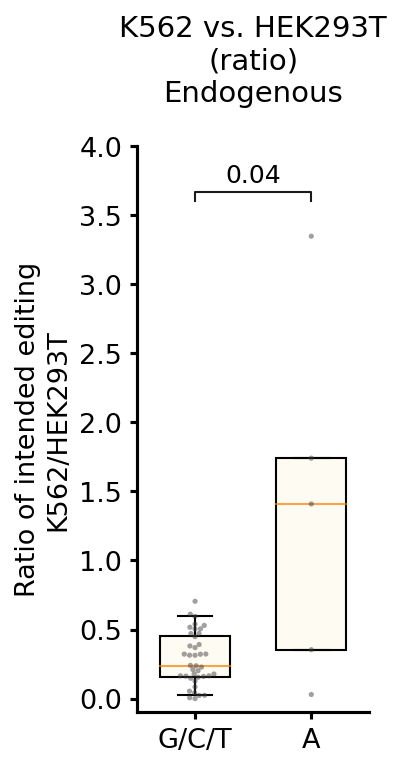

In [399]:
mannwithneyu_test = stats.mannwhitneyu(baseafterA_ratio, baseafterGTC_ratio)
print(mannwithneyu_test[1])

fig2, ax3 = plt.subplots(figsize=(2,5),dpi=150)
ax3.set_title('K562 vs. HEK293T\n(ratio)\nEndogenous\n', fontsize=titlesize)
sn.boxplot(x='baseaftercategory', y='K562_HEK293T_editingratio', data=ahmedfeaturepredictionendogenous,linewidth=1,medianprops=dict(color="#F57F00", alpha=0.7), color='#7fa3d4',whis=[5,95],width=0.6,showfliers = False,ax=ax3)
sn.swarmplot(x="baseaftercategory", y='K562_HEK293T_editingratio', data=ahmedfeaturepredictionendogenous, alpha=0.5, size=2.5, color="#424242",ax=ax3)

sn.despine()

for i,artist in enumerate(ax3.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor('black')
    artist.set_facecolor('#FEFBF3')
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*5,i*5+4):
        if j == 9:
            continue
        line = ax3.lines[j]
        line.set_color('black')
        line.set_mfc('black')
        line.set_mec('black')
ax3.set_ylim(-0.1, 4)
ax3.set_ylabel('Ratio of intended editing\nK562/HEK293T', fontsize=lsize)
ax3.set(xlabel=None)
ax3.tick_params(axis='x', labelsize= lsize, width=1.5)
ax3.tick_params(axis='y', labelsize= lsize, width=1.5)

### add significance stars to plot ###
x1, x2 = 0,1   # between which boxes should the line be?
y1,y2 = 3.6,3.67
ax3.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
ax3.text((x1+x2)*.5, y1 +0.1, round(mannwithneyu_test[1],2), ha='center', va='bottom',fontsize=12)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup9_Subscreen\\'
plt.savefig(figurepath+'K562_HEK293T_ratio_baseafterA.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [400]:
lowendogenous = ahmedpredictionendogenous[ahmedpredictionendogenous['pred_averageedited'] <50].copy()
highendogenous = ahmedpredictionendogenous[ahmedpredictionendogenous['pred_averageedited'] >50].copy()
print(len(lowendogenous),len(highendogenous))

20 25


In [401]:
lowk562endogenous_R = stats.spearmanr(lowendogenous['K562_truescore'],lowendogenous[predscore])[0]
highk562endogenous_R = stats.spearmanr(highendogenous['K562_truescore'],highendogenous[predscore])[0]

lowk562endogenous_r = stats.pearsonr(lowendogenous['K562_truescore'],lowendogenous[predscore])[0]
highk562endogenous_r = stats.pearsonr(highendogenous['K562_truescore'],highendogenous[predscore])[0]

binned_R = [lowk562endogenous_R,highk562endogenous_R]
binned_r = [lowk562endogenous_r,highk562endogenous_r]
print(lowk562endogenous_R,highk562endogenous_R)

0.4812030075187969 0.5669230769230769


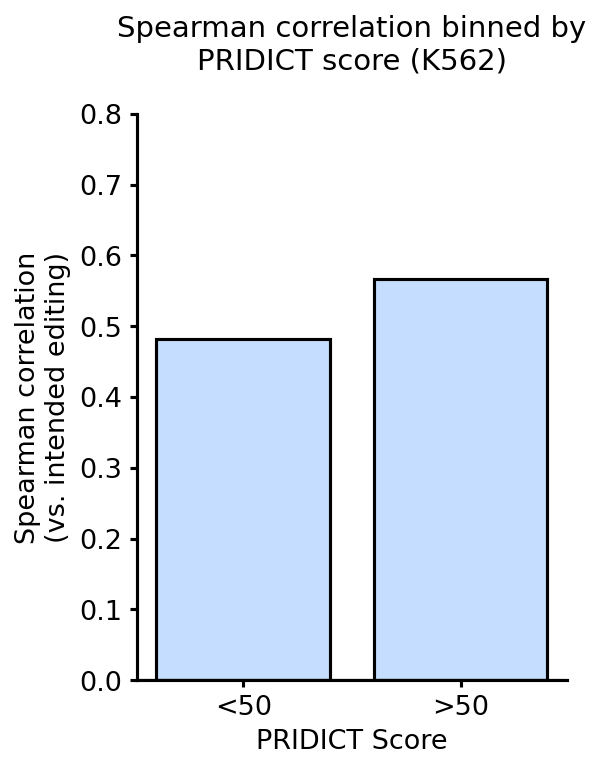

In [402]:
labels = ['<50','>50']

fig17, ax17 = plt.subplots(figsize = (3.7, 5),dpi=150)
ax17.set_title('Spearman correlation binned by\nPRIDICT score (K562)\n', fontsize=titlesize)
ax17.bar(labels, binned_R, **bar_kwargs)
ax17.set_ylabel('Spearman correlation\n(vs. intended editing)', fontsize=lsize)
ax17.set_xlabel('PRIDICT Score', fontsize=lsize)
ax17.spines['right'].set_visible(False)
ax17.spines['top'].set_visible(False)
ax17.set_ylim(0,0.8)
ax17.tick_params(axis='x', labelsize= lsize, width=1.5)
ax17.tick_params(axis='y', labelsize= lsize, width=1.5)
ax17.axhline(0, color = 'black')

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'K562_endoefficiency_PRIDICT_BinnedSpearman.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

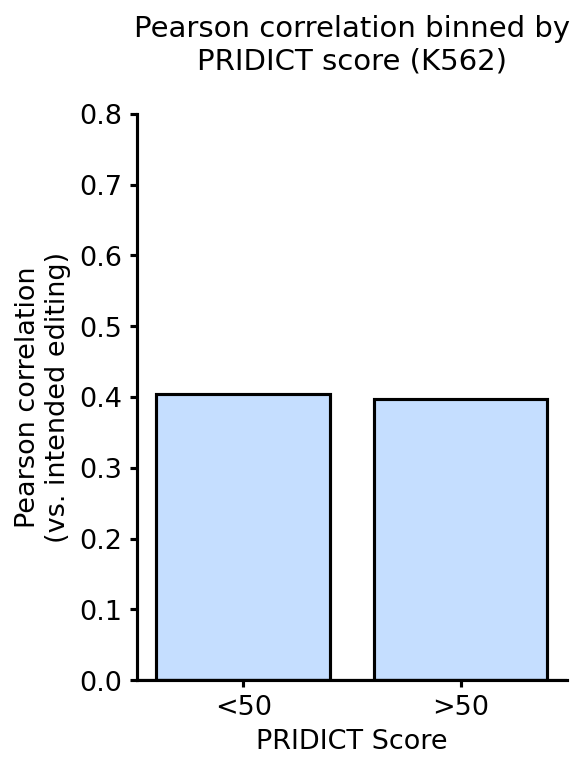

In [403]:
labels = ['<50','>50']

fig17, ax17 = plt.subplots(figsize = (3.7, 5),dpi=150)
ax17.set_title('Pearson correlation binned by\nPRIDICT score (K562)\n', fontsize=titlesize)
ax17.bar(labels, binned_r, **bar_kwargs)
ax17.set_ylabel('Pearson correlation\n(vs. intended editing)', fontsize=lsize)
ax17.set_xlabel('PRIDICT Score', fontsize=lsize)
ax17.spines['right'].set_visible(False)
ax17.spines['top'].set_visible(False)
ax17.set_ylim(0,0.8)
ax17.tick_params(axis='x', labelsize= lsize, width=1.5)
ax17.tick_params(axis='y', labelsize= lsize, width=1.5)
ax17.axhline(0, color = 'black')

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'K562_endoefficiency_PRIDICT_BinnedPearson.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [404]:
truescore_indel_K562 = 'true_K562_averageindel'
predscore_indel = 'pred_averageindel'

ahmedpredictionendogenous[truescore_indel_K562] = endogenousK562df['average_indel_between_bio_replicates'].copy()
ahmedpredictionendogenous[truescore_indel_K562] = ahmedpredictionendogenous[truescore_indel_K562].apply(lambda x: 0 if x < 0 else x)

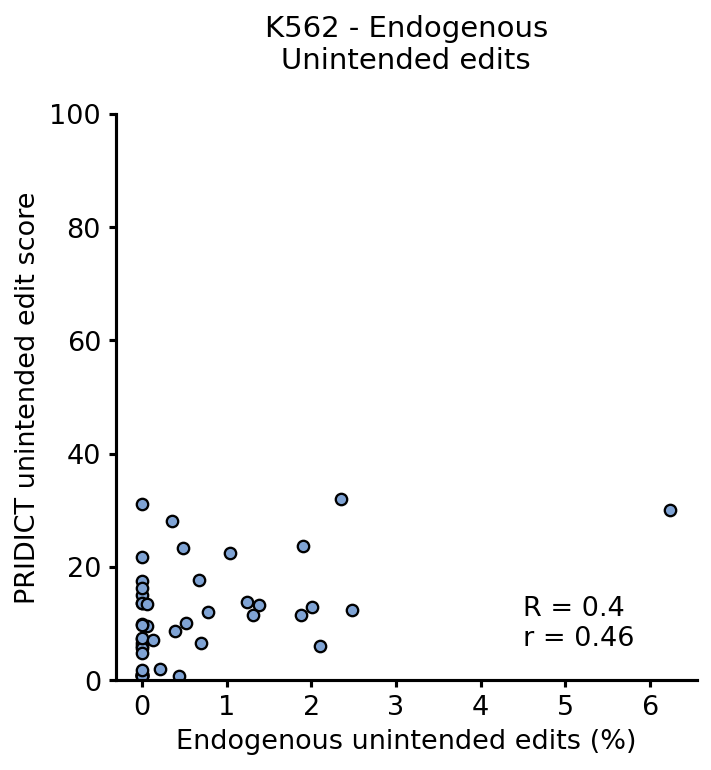

In [405]:

endovspridict_R = stats.spearmanr(ahmedpredictionendogenous[truescore_indel_K562],ahmedpredictionendogenous[predscore_indel])[0]
K562endoindel_R = endovspridict_R
endovspridict_r = stats.pearsonr(ahmedpredictionendogenous[truescore_indel_K562],ahmedpredictionendogenous[predscore_indel])[0]

fig2, ax2 = plt.subplots(figsize=(5,5),dpi=150)
ax2.scatter(ahmedpredictionendogenous[truescore_indel_K562],ahmedpredictionendogenous[predscore_indel], c='#7fa3d4',s=30,edgecolor='black',linewidths=1.1)
ax2.set_title('K562 - Endogenous\nUnintended edits\n', fontsize=14)
ax2.set_xlabel('Endogenous unintended edits (%)', fontsize=13)
ax2.set_ylabel('PRIDICT unintended edit score', fontsize=13)
ax2.tick_params(axis='x', labelsize= 13, width=1.5)
ax2.tick_params(axis='y', labelsize= 13, width=1.5)
m, b = np.polyfit(ahmedpredictionendogenous[truescore_indel_K562],ahmedpredictionendogenous[predscore_indel], 1)
ax2.set_ylim(0,100)
ax2.text(0.7,0.15, 'R = '+str(round(endovspridict_R, 2))+'\nr = '+str(round(endovspridict_r, 2)), transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

## HEK293T vs K562 editing

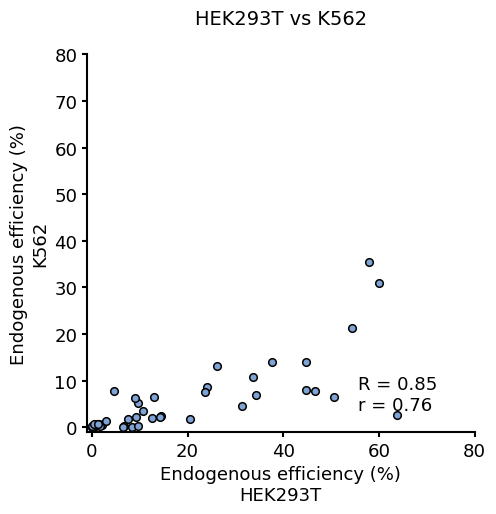

In [406]:
endovspridict_R = stats.spearmanr(endogenousHEKdf['average_between_bio_replicates'],endogenousK562df['average_between_bio_replicates'])[0]
endovspridict_r = stats.pearsonr(endogenousHEKdf['average_between_bio_replicates'],endogenousK562df['average_between_bio_replicates'])[0]

fig2, ax2 = plt.subplots(1,1,figsize = (5, 5),dpi=100)
ax2.scatter(endogenousHEKdf['average_between_bio_replicates'],endogenousK562df['average_between_bio_replicates'], c='#7fa3d4',s=30,edgecolor='black',linewidths=1.1)
ax2.set_title('HEK293T vs K562\n', fontsize=14)
ax2.set_xlabel('Endogenous efficiency (%)\nHEK293T', fontsize=13)
ax2.set_ylabel('Endogenous efficiency (%)\nK562', fontsize=13)
ax2.tick_params(axis='x', labelsize= 13, width=1.5)
ax2.tick_params(axis='y', labelsize= 13, width=1.5)
m, b = np.polyfit(endogenousHEKdf['average_between_bio_replicates'],endogenousK562df['average_between_bio_replicates'], 1)
ax2.set_ylim(-1,80)
ax2.set_xlim(-1,80)
ax2.text(0.7,0.15, 'R = '+str(round(endovspridict_R, 2))+'\nr = '+str(round(endovspridict_r,2)), transform=ax2.transAxes, fontsize=13,
        verticalalignment='top')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'K562vsHEK293T_endogenous_editing.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

## Comparison unintended edit - library vs endogenous

[0.7792863068060437, 0.3330075688962027, 0.39629785619108804]

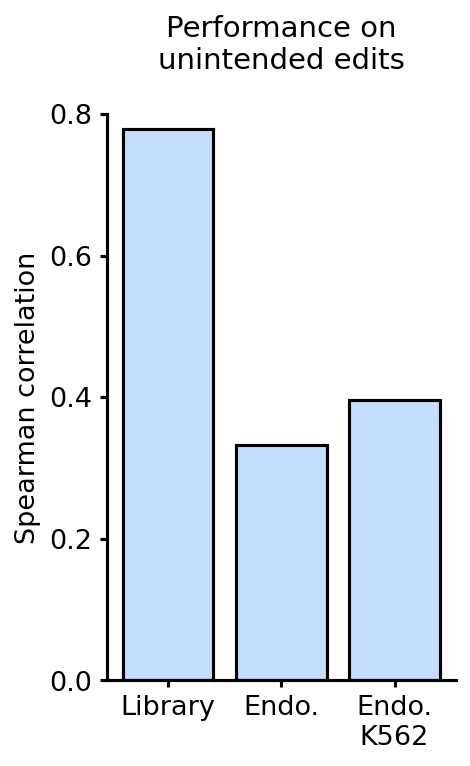

In [407]:
indelspearmanlist = [averageindelspearmanscore,HEKendoindel_R,K562endoindel_R]
labels = ['Library','Endo.', 'Endo.\nK562']

fig17, ax17 = plt.subplots(figsize = (3, 5),dpi=150)
ax17.set_title('Performance on\nunintended edits\n', fontsize=titlesize)
ax17.bar(labels, indelspearmanlist, **bar_kwargs)
ax17.set_ylabel('Spearman correlation', fontsize=lsize)
ax17.spines['right'].set_visible(False)
ax17.spines['top'].set_visible(False)
#ax17.get_children()[0].set_facecolor('#9AFFB5')
ax17.set_ylim(0.0,0.8)
ax17.set_yticks(list(np.arange(0,0.9,0.2)))
ax17.tick_params(axis='x', labelsize= lsize, width=1.5)
ax17.tick_params(axis='y', labelsize= lsize, width=1.5)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\04_Validation_Endogenous\\'
plt.savefig(figurepath+'performance_unintended_edits.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
indelspearmanlist

## PRIDICT prediction of Anzalone et al. values

In [408]:
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_anzalone_PE2\\exp_2022-07-19_18-10-44\\"

truescore = 'true_averageedited'
predscore = 'pred_averageedited'
anzalonepe2df = pd.read_csv(path+'pred_df_wsize20.csv')
anzalonepe2df = anzalonepe2df.set_index('seq_id')
anzalonepe2df_full = pd.read_csv(path+'df_anzalone.csv')
anzalonepe2df_full = anzalonepe2df_full.set_index('seq_id')
anzalonepe2df_full[truescore] = anzalonepe2df[truescore]
anzalonepe2df_full[predscore] = anzalonepe2df[predscore]
anzalonepe2df = anzalonepe2df_full
anzalonepe2df[truescore] = anzalonepe2df[truescore].apply(lambda x: x*100)
anzalonepe2df[predscore] = anzalonepe2df[predscore].apply(lambda x: x*100)

In [409]:
anzapreddfhigh = anzalonepe2df[anzalonepe2df['pred_averageedited'] > 70]
anzapreddflow = anzalonepe2df[anzalonepe2df['pred_averageedited'] < 70]

highloweditdata= [anzapreddflow[truescore], anzapreddfhigh[truescore]]
highlowxticks= ['PRIDICT < 70', 'PRIDICT > 70' ]
anzalone_mannwithneyu_test = stats.mannwhitneyu(anzapreddfhigh[truescore], anzapreddflow[truescore])
anzalone_mannwithneyu_test[1]


1.1967949813351326e-16

In [410]:
libpreddfhigh = run2df[run2df[predscore] > 70]
libpreddflow = run2df[run2df[predscore] < 70]

libhighloweditdata = [libpreddflow[truescore], libpreddfhigh[truescore]]
libhighlowxticks = ['<70','\nPRIDICT score', '>70']

libhek_mannwithneyu_test = stats.mannwhitneyu(libpreddfhigh[truescore], libpreddflow[truescore])
libhek_mannwithneyu_test[1]

0.0

In [411]:
preddfhigh = ahmedpredictionendogenous[ahmedpredictionendogenous[predscore] > 70]
preddflow = ahmedpredictionendogenous[ahmedpredictionendogenous[predscore] < 70]

anzalonehigh = anzalonepe2df[anzalonepe2df['pred_averageedited'] > 70]
anzalonelow = anzalonepe2df[anzalonepe2df['pred_averageedited'] < 70]

highloweditdata= [libhighloweditdata[0], libhighloweditdata[1],preddflow['true_averageedited'], preddfhigh['true_averageedited'], preddflow['K562_truescore'], preddfhigh['K562_truescore'], anzalonelow['true_averageedited'], anzalonehigh['true_averageedited']]
highlowxticks= ['<70', '>70','<70', '>70', '<70', '>70', '<70', '>70']
highlowxticks.insert(7,'\nAnzalone\nEndogenous Edits')
highlowxticks.insert(5,'\nK562\nEndogenous Edits')
highlowxticks.insert(3,'\nHEK\nEndogenous Edits')
highlowxticks.insert(1,'\nLibrary Edits')

HEKendohighlowxticks = ['<70','\nPRIDICT score', '70+']
HEKendohighloweditdata = [preddflow['true_averageedited'], preddfhigh['true_averageedited']]

K562highlowxticks = ['<70','\nPRIDICT score', '>70']
K562highloweditdata = [preddflow['K562_truescore'], preddfhigh['K562_truescore']]

Anzalonehighlowxticks = ['<70','\nPRIDICT score', '>70']
Anzalonehighloweditdata = [anzalonelow['true_averageedited'], anzalonehigh['true_averageedited']]


endohek_mannwithneyu_test = stats.mannwhitneyu(preddfhigh['true_averageedited'], preddflow['true_averageedited'])
print(endohek_mannwithneyu_test[1])

endohek_mannwithneyu_test = stats.mannwhitneyu(preddfhigh['K562_truescore'], preddflow['K562_truescore'])
print(endohek_mannwithneyu_test[1])

endohek_mannwithneyu_test = stats.mannwhitneyu(anzalonehigh['true_averageedited'], anzalonelow['true_averageedited'])
print(endohek_mannwithneyu_test[1])


2.2515242808113127e-06
5.562049258187391e-06
1.1967949813351326e-16


In [412]:
run2df['scorelevel'] = run2df[predscore].apply(lambda x: '>70' if x > 70 else ('<70' if x < 70 else None))
highlowpe2df = run2df.dropna(subset = ['scorelevel'])
lowpercentile = highlowpe2df[highlowpe2df['scorelevel'] == '<70']['true_averageedited'].quantile(q=0.05)
highpercentile = highlowpe2df[highlowpe2df['scorelevel'] == '<70']['true_averageedited'].quantile(q=0.95)

#highlowpe2df[(highlowpe2df['scorelevel'] == '<70') & ((highlowpe2df['true_averageedited'] < lowpercentile))]['true_averageedited']

lowpridictoutlierdf = pd.DataFrame()
lowpridictoutlierdf['outliervalue'] = highlowpe2df[(highlowpe2df['scorelevel'] == '<70') & ((highlowpe2df['true_averageedited'] < lowpercentile) | (highlowpe2df['true_averageedited'] > highpercentile))]['true_averageedited']
lowpridictoutlierdf['predlevel'] = '<70'

lowpercentile = highlowpe2df[highlowpe2df['scorelevel'] == '>70']['true_averageedited'].quantile(q=0.05)
highpercentile = highlowpe2df[highlowpe2df['scorelevel'] == '>70']['true_averageedited'].quantile(q=0.95)
highpridictoutlierdf = pd.DataFrame()
highpridictoutlierdf['outliervalue'] = highlowpe2df[(highlowpe2df['scorelevel'] == '>70') & ((highlowpe2df['true_averageedited'] < lowpercentile) | (highlowpe2df['true_averageedited'] > highpercentile))]['true_averageedited']
highpridictoutlierdf['predlevel'] = '>70'

outlierdf = lowpridictoutlierdf.append(highpridictoutlierdf)


16150
2335


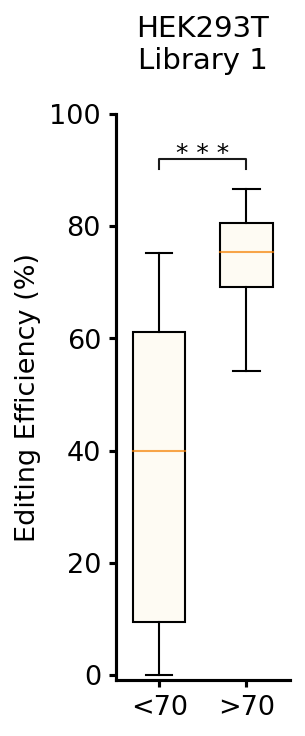

In [413]:
run2df['scorelevel'] = run2df[predscore].apply(lambda x: '>70' if x > 70 else ('<70' if x < 70 else None))
highlowpe2df = run2df.dropna(subset = ['scorelevel'])

fig2, ax3 = plt.subplots(figsize=(1.5,5),dpi=150)
ax3.set_title('HEK293T\nLibrary 1\n', fontsize=titlesize)
sn.boxplot(x='scorelevel', y='true_averageedited', data=highlowpe2df,linewidth=1,medianprops=dict(color="#F57F00", alpha=0.7), color='#7fa3d4',whis=[5,95],width=0.6,showfliers = False,ax=ax3)
#sns.stripplot(x="predlevel", y='outliervalue', data=outlierdf, alpha=0.5, size=1, color="#424242",ax=ax3)

sn.despine()

for i,artist in enumerate(ax3.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor('black')
    artist.set_facecolor('#FEFBF3')
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*5,i*5+4):
        if j == 9:
            continue
        line = ax3.lines[j]
        line.set_color('black')
        line.set_mfc('black')
        line.set_mec('black')
ax3.set_ylim(-1, 100)
ax3.set_xticklabels(['<70','>70'])
#ax3.set_xlabel('Editing Length', fontsize=lsize)
ax3.set_ylabel('Editing Efficiency (%)', fontsize=lsize)
ax3.set(xlabel=None)
ax3.tick_params(axis='x', labelsize= lsize, width=1.5)
ax3.tick_params(axis='y', labelsize= lsize, width=1.5)

### add significance stars to plot ###
x1, x2 = 0,1   # between which boxes should the line be?
y1,y2 = 90.2,92
ax3.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
ax3.text((x1+x2)*.5, y1 +0.5, "* * *", ha='center', va='bottom',fontsize=12)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\04_Validation_Endogenous\\'
plt.savefig(figurepath+'High_Low_PRIDICT_Score_Library.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

print(len(highlowpe2df[highlowpe2df['scorelevel'] == '<70']))
print(len(highlowpe2df[highlowpe2df['scorelevel'] == '>70']))

30
15
index                          26.500000
true_averageedited              3.702143
true_averageindel               0.002303
pred_averageedited             41.590289
pred_averageunedited            0.383741
pred_averageindel              13.469901
new_seq_id                     20.500000
true_HEK293T_averageindel       0.230288
K562_truescore                  0.652369
K562_unintended_truescore       0.097137
K562_diff_editing_true_pred   -38.348732
k562higher                      0.000000
true_K562_averageindel          0.097137
dtype: float64
index                          17.000000
true_averageedited             37.645310
true_averageindel               0.000000
pred_averageedited             76.728849
pred_averageunedited            0.158781
pred_averageindel               7.193429
new_seq_id                     24.000000
true_HEK293T_averageindel       0.000000
K562_truescore                  7.987694
K562_unintended_truescore       0.000000
K562_diff_editing_true_pred   -66.56

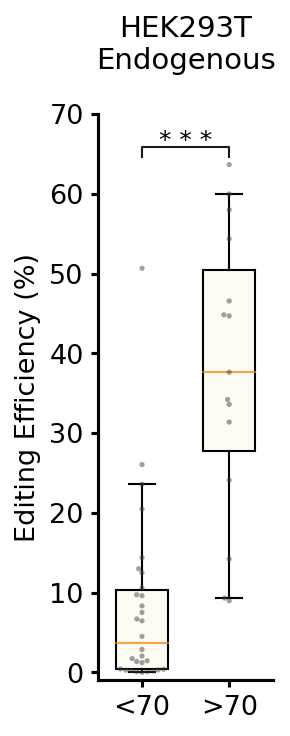

In [414]:
ahmedpredictionendogenous['scorelevel'] = ahmedpredictionendogenous[predscore].apply(lambda x: '>70' if x > 70 else ('<70' if x < 70 else None))
highlowpe2df = ahmedpredictionendogenous.dropna(subset = ['scorelevel'])

fig2, ax3 = plt.subplots(figsize=(1.5,5),dpi=150)
ax3.set_title('HEK293T\nEndogenous\n', fontsize=titlesize)
sn.boxplot(x='scorelevel', y='true_averageedited', data=highlowpe2df,linewidth=1,medianprops=dict(color="#F57F00", alpha=0.7), color='#7fa3d4',whis=[5,95],width=0.6,showfliers = False,ax=ax3)
sn.swarmplot(x="scorelevel", y='true_averageedited', data=highlowpe2df, alpha=0.5, size=2.5, color="#424242",ax=ax3)

sn.despine()

for i,artist in enumerate(ax3.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor('black')
    artist.set_facecolor('#FEFBF3')
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*5,i*5+4):
        if j == 9:
            continue
        line = ax3.lines[j]
        line.set_color('black')
        line.set_mfc('black')
        line.set_mec('black')
ax3.set_ylim(-1, 70)
ax3.set_xticklabels(['<70','>70'])
#ax3.set_xlabel('Editing Length', fontsize=lsize)
ax3.set_ylabel('Editing Efficiency (%)', fontsize=lsize)
ax3.set(xlabel=None)
ax3.tick_params(axis='x', labelsize= lsize, width=1.5)
ax3.tick_params(axis='y', labelsize= lsize, width=1.5)

### add significance stars to plot ###
x1, x2 = 0,1   # between which boxes should the line be?
y1,y2 = 64.6,65.9
ax3.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
ax3.text((x1+x2)*.5, y1 +0.5, "* * *", ha='center', va='bottom',fontsize=12)


figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\04_Validation_Endogenous\\'
plt.savefig(figurepath+'High_Low_PRIDICT_Score_HEKendo.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

print(len(highlowpe2df[highlowpe2df['scorelevel'] == '<70']))
print(len(highlowpe2df[highlowpe2df['scorelevel'] == '>70']))

print(highlowpe2df[highlowpe2df['scorelevel'] == '<70'].median())
print(highlowpe2df[highlowpe2df['scorelevel'] == '>70'].median())

0.6523685018413325
7.987694394569666
30
15


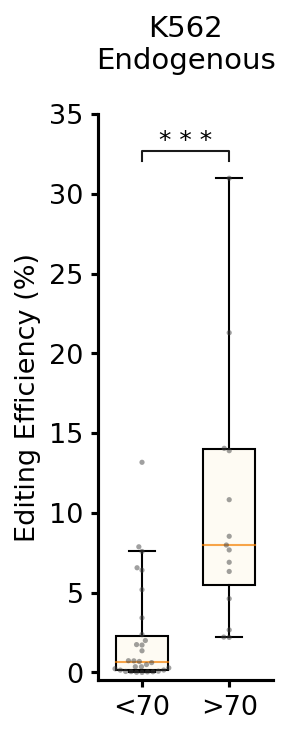

In [415]:
ahmedpredictionendogenous['scorelevel'] = ahmedpredictionendogenous[predscore].apply(lambda x: '>70' if x > 70 else ('<70' if x < 70 else None))
highlowpe2df = ahmedpredictionendogenous.dropna(subset = ['scorelevel'])

fig2, ax3 = plt.subplots(figsize=(1.5,5),dpi=150)
ax3.set_title('K562\nEndogenous\n', fontsize=titlesize)
sn.boxplot(x='scorelevel', y='K562_truescore', data=highlowpe2df,linewidth=1,medianprops=dict(color="#F57F00", alpha=0.7), color='#7fa3d4',whis=[5,95],width=0.6,showfliers = False,ax=ax3)
sn.swarmplot(x="scorelevel", y='K562_truescore', data=highlowpe2df, alpha=0.5, size=2.5, color="#424242",ax=ax3)

sn.despine()

for i,artist in enumerate(ax3.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor('black')
    artist.set_facecolor('#FEFBF3')
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*5,i*5+4):
        if j == 9:
            continue
        line = ax3.lines[j]
        line.set_color('black')
        line.set_mfc('black')
        line.set_mec('black')
ax3.set_ylim(-0.5, 35)
ax3.set_xticklabels(['<70','>70'])
#ax3.set_xlabel('Editing Length', fontsize=lsize)
ax3.set_ylabel('Editing Efficiency (%)', fontsize=lsize)
ax3.set(xlabel=None)
ax3.tick_params(axis='x', labelsize= lsize, width=1.5)
ax3.tick_params(axis='y', labelsize= lsize, width=1.5)

### add significance stars to plot ###
x1, x2 = 0,1   # between which boxes should the line be?
y1,y2 = 32.05,32.7
ax3.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
ax3.text((x1+x2)*.5, y1 +0.5, "* * *", ha='center', va='bottom',fontsize=12)
print(K562highloweditdata[0].median())
print(K562highloweditdata[1].median())
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\04_Validation_Endogenous\\'
plt.savefig(figurepath+'High_Low_PRIDICT_Score_K562.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

print(len(highlowpe2df[highlowpe2df['scorelevel'] == '<70']))
print(len(highlowpe2df[highlowpe2df['scorelevel'] == '>70']))

112
69


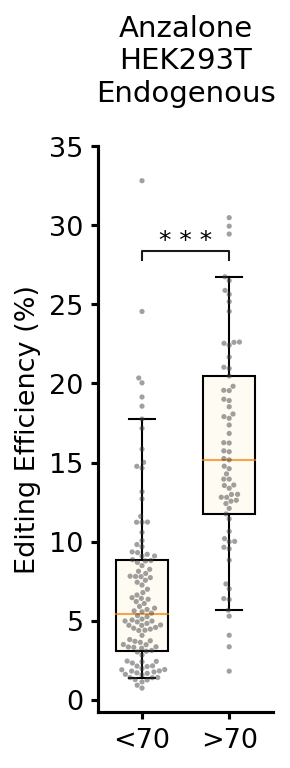

In [416]:
anzalonepe2df['scorelevel'] = anzalonepe2df[predscore].apply(lambda x: '>70' if x > 70 else ('<70' if x < 70 else None))
highlowpe2df = anzalonepe2df.dropna(subset = ['scorelevel'])

fig2, ax3 = plt.subplots(figsize=(1.5,5),dpi=150)
ax3.set_title('Anzalone\nHEK293T\nEndogenous\n', fontsize=titlesize)
sn.boxplot(x='scorelevel', y='true_averageedited', data=highlowpe2df,linewidth=1,medianprops=dict(color="#F57F00", alpha=0.7), color='#7fa3d4',whis=[5,95],width=0.6,showfliers = False,ax=ax3)
sn.swarmplot(x="scorelevel", y='true_averageedited', data=highlowpe2df, alpha=0.5, size=2.5, color="#424242",ax=ax3)

sn.despine()

for i,artist in enumerate(ax3.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor('black')
    artist.set_facecolor('#FEFBF3')
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*5,i*5+4):
        if j == 9:
            continue
        line = ax3.lines[j]
        line.set_color('black')
        line.set_mfc('black')
        line.set_mec('black')
ax3.set_ylim(-0.8, 35)
ax3.set_xticklabels(['<70','>70'])
#ax3.set_xlabel('Editing Length', fontsize=lsize)
ax3.set_ylabel('Editing Efficiency (%)', fontsize=lsize)
ax3.set(xlabel=None)
ax3.tick_params(axis='x', labelsize= lsize, width=1.5)
ax3.tick_params(axis='y', labelsize= lsize, width=1.5)

### add significance stars to plot ###
x1, x2 = 0,1   # between which boxes should the line be?
y1,y2 = 27.8,28.4
ax3.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
ax3.text((x1+x2)*.5, y1 +0.5, "* * *", ha='center', va='bottom',fontsize=12)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\04_Validation_Endogenous\\'
plt.savefig(figurepath+'High_Low_PRIDICT_Score_Anzalone.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

print(len(highlowpe2df[highlowpe2df['scorelevel'] == '<70']))
print(len(highlowpe2df[highlowpe2df['scorelevel'] == '>70']))

## Analysis of editing and pridict score variablity within each locus

In [417]:
variabilitydf = ahmedpredictionendogenous.set_index('name')
locilist = ['01','03','05','06','09','17','20','26','28','31','33','EMX12b10','FANCF2b10','HEK32b20','RNF22b14']

summaryHEKeditingvariability = []
summaryK562editingvariability = []
summarypredictionvariability = []
summarystddevHEKeditingvariability = []
summarystddevK562editingvariability = []
summarystddevpredictionvariability = []


heklocieditlist = []
k562locieditlist = []
predictionlist = []
ratioHEKediting = []
ratioK562editing = []
ratioprediction = []

for locus in locilist:
    HEKlocusediting = []
    K562locusediting = []
    locusprediction = []
    for peg in ['libbestpeg','libendopeg','libworstpeg']:
        HEKlocusediting.append(variabilitydf.at[locus+peg, 'true_averageedited'])
        K562locusediting.append(variabilitydf.at[locus+peg, 'K562_truescore'])
        locusprediction.append(variabilitydf.at[locus+peg, 'pred_averageedited'])
    HEKminediting = min(HEKlocusediting)
    HEKmaxediting = max(HEKlocusediting)
    K562minediting = min(K562locusediting)
    K562maxediting = max(K562locusediting)
    minprediction = min(locusprediction)
    maxprediction = max(locusprediction)
    summaryHEKeditingvariability.append(HEKmaxediting-HEKminediting)
    summaryK562editingvariability.append(K562maxediting-K562minediting)
    summarypredictionvariability.append(maxprediction-minprediction)
    summarystddevHEKeditingvariability.append(np.std(HEKlocusediting))
    summarystddevK562editingvariability.append(np.std(K562locusediting))
    summarystddevpredictionvariability.append(np.std(locusprediction))
    heklocieditlist.append(sum(HEKlocusediting)/len(HEKlocusediting))
    k562locieditlist.append(sum(K562locusediting)/len(K562locusediting))
    predictionlist.append(sum(locusprediction)/len(locusprediction))
    ratioHEKediting.append(HEKmaxediting/HEKminediting)
    ratioK562editing.append(K562maxediting/K562minediting)
    ratioprediction.append(maxprediction/minprediction)

variabilitydict = {'HEK':summarystddevHEKeditingvariability,'K562':summarystddevK562editingvariability,'prediction':summarystddevpredictionvariability}
plotvariabilitydf = pd.DataFrame()

index = 0
for x in ['HEK','K562','prediction']:
    for element in variabilitydict[x]:
        plotvariabilitydf.at[index, 'value'] = element
        plotvariabilitydf.at[index, 'type'] = x
        index+=1
        
locusvariabilitydict = {'HEK':heklocieditlist,'K562':k562locieditlist,'prediction':predictionlist}
locusvariabilitydf = pd.DataFrame()

index = 0
for x in ['HEK','K562','prediction']:
    for element in locusvariabilitydict[x]:
        locusvariabilitydf.at[index, 'value'] = element
        locusvariabilitydf.at[index, 'type'] = x
        index+=1

meanintralocusstddevlist = []
for x in ['HEK','K562','prediction']:
    meanintralocusstddevlist.append(plotvariabilitydf[plotvariabilitydf['type'] == x]['value'].mean())
        
        
interlocusstddevlist = []
for x in ['HEK','K562','prediction']:
    interlocusstddevlist.append(locusvariabilitydf[locusvariabilitydf['type'] == x]['value'].std())
    
intrainterpredictionstddevlist = [plotvariabilitydf[plotvariabilitydf['type'] == 'prediction']['value'].mean(),locusvariabilitydf[locusvariabilitydf['type'] == 'prediction']['value'].std()]

C:\Users\nimath\AppData\Local\Temp/ipykernel_14344/3505881541.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  ratioK562editing.append(K562maxediting/K562minediting)


value    10.810177
dtype: float64
value    3.013891
dtype: float64
value    13.283404
dtype: float64
HEK endo editing median: 9.620605431
K562 endo editing median: 2.1975900716006547
endo prediction median: 61.05336904525757


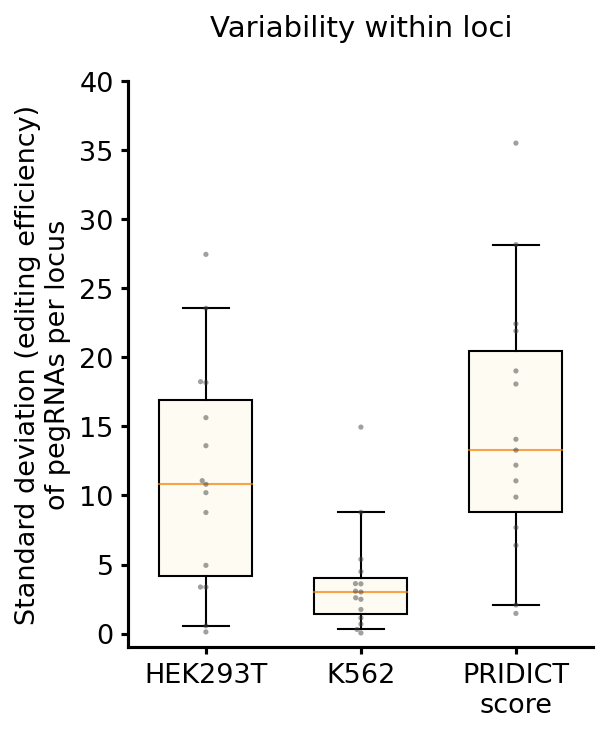

In [418]:
fig2, ax3 = plt.subplots(figsize=(4,5),dpi=150)
ax3.set_title('Variability within loci\n', fontsize=titlesize)
sn.boxplot(x='type', y='value', data=plotvariabilitydf,linewidth=1,medianprops=dict(color="#F57F00", alpha=0.7), color='#7fa3d4',whis=[5,95],width=0.6,showfliers = False,ax=ax3)
sn.swarmplot(x="type", y='value', data=plotvariabilitydf, alpha=0.5, size=2.5, color="#424242",ax=ax3)

sn.despine()

for i,artist in enumerate(ax3.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor('black')
    artist.set_facecolor('#FEFBF3')
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*5,i*5+4):
        if j == 9:
            continue
        line = ax3.lines[j]
        line.set_color('black')
        line.set_mfc('black')
        line.set_mec('black')
ax3.set_ylim(-1, 40)
ax3.set_xticklabels(['HEK293T','K562','PRIDICT\nscore'])
ax3.set_ylabel('Standard deviation (editing efficiency)\nof pegRNAs per locus', fontsize=lsize)
ax3.set(xlabel=None)
ax3.tick_params(axis='x', labelsize= lsize, width=1.5)
ax3.tick_params(axis='y', labelsize= lsize, width=1.5)




figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'variability_endogenous_edits.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


print(plotvariabilitydf[plotvariabilitydf['type'] == 'HEK'].median())
print(plotvariabilitydf[plotvariabilitydf['type'] == 'K562'].median())
print(plotvariabilitydf[plotvariabilitydf['type'] == 'prediction'].median())

print('HEK endo editing median:',variabilitydf['true_averageedited'].median())
print('K562 endo editing median:',variabilitydf['K562_truescore'].median())
print('endo prediction median:',variabilitydf['pred_averageedited'].median())

In [419]:
plotvariabilitydf

value        type
0   15.637678         HEK
1    4.943743         HEK
2    0.121188         HEK
3    0.565015         HEK
4   11.074917         HEK
5   10.810177         HEK
6   18.175189         HEK
7   18.242854         HEK
8   10.205564         HEK
9   23.553138         HEK
10   8.769970         HEK
11   3.365572         HEK
12  13.606143         HEK
13   3.372533         HEK
14  27.458590         HEK
15   2.593468        K562
16   2.487084        K562
17   0.047641        K562
18   0.300083        K562
19   1.746129        K562
20   5.379982        K562
21  14.952580        K562
22   3.076493        K562
23   3.603801        K562
24   8.781234        K562
25   3.013891        K562
26   3.619496        K562
27   4.488829        K562
28   0.688514        K562
29   1.135116        K562
30  13.283404  prediction
31  19.018257  prediction
32   1.461932  prediction
33   2.074613  prediction
34   6.388704  prediction
35  22.429988  prediction
36   7.678645  prediction
37  11.061059  prediction
38   9.885453  prediction
39  35.515090  prediction
40  12.195492  prediction
41  21.910227  prediction
42  28.161291  prediction
43  14.072186  prediction
44  18.071291  prediction

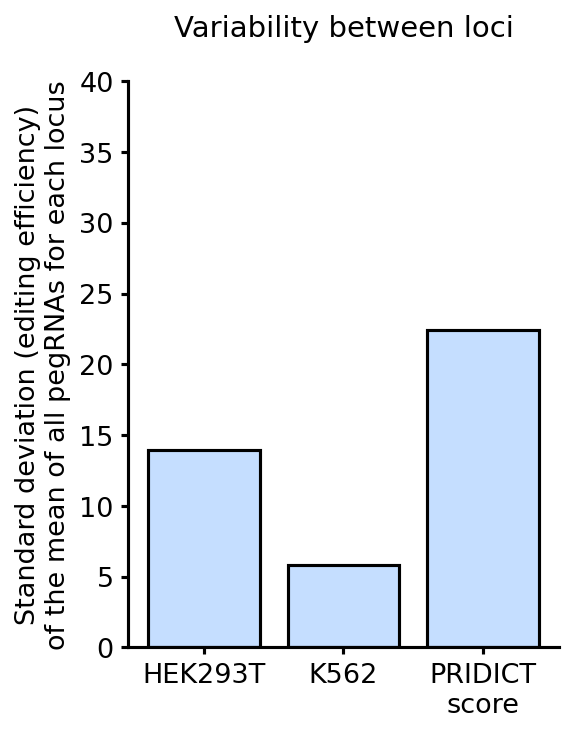

In [287]:
labels = ['HEK293T','K562','PRIDICT\nscore']

fig17, ax17 = plt.subplots(figsize = (3.7, 5),dpi=150)
ax17.set_title('Variability between loci\n', fontsize=titlesize)
ax17.bar(labels, interlocusstddevlist, **bar_kwargs)
ax17.set_ylabel('Standard deviation (editing efficiency)\nof the mean of all pegRNAs for each locus', fontsize=lsize)
ax17.spines['right'].set_visible(False)
ax17.spines['top'].set_visible(False)
ax17.set_ylim(0.0,40)
ax17.tick_params(axis='x', labelsize= lsize, width=1.5)
ax17.tick_params(axis='y', labelsize= lsize, width=1.5)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'variability_betweenloci_endogenous_edits.pdf', format='pdf',
        transparent=True,bbox_inches='tight')


## Chromatin analysis

In [290]:
chromatinpath = "C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\"
chromatin_HEK293_1kdf = pd.read_csv(chromatinpath+'HEK293T_normalized.tsv', sep='\t')
chromatin_HEK293_1kdf = chromatin_HEK293_1kdf.set_index('name')
chromatin_K562_1kdf = pd.read_csv(chromatinpath+'K562_normalized.tsv', sep='\t')
chromatin_K562_1kdf = chromatin_K562_1kdf.set_index('name')

In [291]:
#import dataframe with editing rates of endogenous edits which were integrated via lentivirus reporter (for comparison to endogenous site)
endolibraryediting = pd.read_csv('20220730_library1_endogenousedits_templatedf_with_averages.csv', index_col='locus')
endolibraryediting = endolibraryediting.set_index('Name')

In [292]:
openclosedpath = 'C:/Users/nimath/switchdrive/Institution/PhD/01_Experiments/05_Prime_Editing/03_DiseaseScreen/05_Validations/02_Arrayed/Open_Closed_Regions/'
opencloseddf = pd.read_csv(openclosedpath+'NGS/20220806_Editing_OpenClosed_HEK293T.csv')
opencloseddf['pegnr'] = opencloseddf['Storagename'].apply(lambda x: '_'.join(x.split('_')[-2:]))
opencloseddf = opencloseddf.set_index('pegnr')
openclosedcharacteristicsdf = pd.read_csv(openclosedpath+'20220610_OpenClosed_pegRNA_Orderings.csv')
openclosedcharacteristicsdf = openclosedcharacteristicsdf.set_index('Name')
opencloseddf['pridictscore'] = openclosedcharacteristicsdf['PRIDICT_editing_Score_deep']
chromatincols = [
       '/HEK293_hg19_ATAC_high_depth_mean.bw','/GSM2902639_HEK293_hg19_DNase.bw',
       '/HEK293_hg19_H3K4me3_ENCFF756EHF.bigWig',
       '/HEK293_hg19_H3K27me3_SRX6369406.bw',
       '/HEK293_hg19_H3K9me3_SRX897641.bw',
       '/HEK293_hg19_H3K36me3_ENCFF704SBO.bigWig']

for col in chromatincols:
    opencloseddf[col] = chromatin_HEK293_1kdf[col]
opencloseddf.columns

k562chromatincols = [
       '/GSM2902637_K562_hg19_ATAC_no_lysis_buffer.bw','/GSM2902638_K562_hg19_DNase.bw',
       '/K562_hg19_H3K4me3_ENCFF291SWG.bigWig',
       '/K562_hg19_H3K27me3_ENCFF312LYO.bigWig',
       '/K562_hg19_H3K9me3_SRX067527.bw',
       '/K562_hg19_H3K36me3_ENCFF745HXR.bigWig']

for col in k562chromatincols:
    opencloseddf[col] = chromatin_K562_1kdf[col]

In [293]:
for index, row in ahmedpredictionendogenous.iterrows():
    if index <= 32:
        ahmedpredictionendogenous.at[index,'locusname'] = 'Kim_et_al_diseaseblock_'+str(row['name'][:2])
    elif 32 < index <= 35:
        ahmedpredictionendogenous.at[index,'locusname'] = 'EMX1_2b_10'
    elif 35 < index <= 38:
        ahmedpredictionendogenous.at[index,'locusname'] = 'FANCF_2b_10'
    elif 38 < index <= 41:
        ahmedpredictionendogenous.at[index,'locusname'] = 'HEK3_2b_20'
    elif 41 < index <= 44:
        ahmedpredictionendogenous.at[index,'locusname'] = 'RNF2_2b_14'

    ahmedpredictionendogenous.at[index, 'libraryediting'] = endolibraryediting.at[ahmedpredictionendogenous.at[index,'locusname'],'averageedited']
    ahmedpredictionendogenous.at[index, 'libraryunintendedediting'] = endolibraryediting.at[ahmedpredictionendogenous.at[index,'locusname'],'averageindel']
    ahmedpredictionendogenous.at[index, 'ratio_editing_integ_endo'] = ahmedpredictionendogenous.at[index, 'libraryediting']/ahmedpredictionendogenous.at[index, 'true_averageedited']
    ahmedpredictionendogenous.at[index, 'ratio_unintendediting_integ_endo'] = ahmedpredictionendogenous.at[index, 'libraryunintendedediting']/ahmedpredictionendogenous.at[index, 'true_averageindel']

    ahmedpredictionendogenous.at[index,'HEK293_DNAse'] = chromatin_HEK293_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/GSM2902639_HEK293_hg19_DNase.bw']
    ahmedpredictionendogenous.at[index,'HEK293_ATAC'] = chromatin_HEK293_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/HEK293_hg19_ATAC_high_depth_mean.bw']
    ahmedpredictionendogenous.at[index,'HEK293_H3K4me3'] = chromatin_HEK293_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/HEK293_hg19_H3K4me3_ENCFF756EHF.bigWig']   
    ahmedpredictionendogenous.at[index,'HEK293_H3K27me3'] = chromatin_HEK293_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/HEK293_hg19_H3K27me3_SRX6369406.bw'] 
    ahmedpredictionendogenous.at[index,'HEK293_H3K9me3'] = chromatin_HEK293_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/HEK293_hg19_H3K9me3_SRX897641.bw'] 
    ahmedpredictionendogenous.at[index,'HEK293_H3K36me3'] = chromatin_HEK293_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/HEK293_hg19_H3K36me3_ENCFF704SBO.bigWig']
    
    ahmedpredictionendogenous.at[index,'K562_DNAse'] = chromatin_K562_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/GSM2902638_K562_hg19_DNase.bw']
    ahmedpredictionendogenous.at[index,'K562_ATAC'] = chromatin_K562_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/GSM2902637_K562_hg19_ATAC_no_lysis_buffer.bw']
    ahmedpredictionendogenous.at[index,'K562_H3K4me3'] = chromatin_K562_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/K562_hg19_H3K4me3_ENCFF291SWG.bigWig']   
    ahmedpredictionendogenous.at[index,'K562_H3K27me3'] = chromatin_K562_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/K562_hg19_H3K27me3_ENCFF312LYO.bigWig'] 
    ahmedpredictionendogenous.at[index,'K562_H3K9me3'] = chromatin_K562_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/K562_hg19_H3K9me3_SRX067527.bw'] 
    ahmedpredictionendogenous.at[index,'K562_H3K36me3'] = chromatin_K562_1kdf.at[ahmedpredictionendogenous.at[index,'locusname'],'/K562_hg19_H3K36me3_ENCFF745HXR.bigWig']
    
        
ahmedpredictionendogenous['HEK_diff_editing_true_pred'] = ahmedpredictionendogenous['true_averageedited'] -  ahmedpredictionendogenous['pred_averageedited']
ahmedpredictionendogenous['HEK_diff_unintended_editing_true_pred'] = ahmedpredictionendogenous['true_averageindel'] -  ahmedpredictionendogenous['pred_averageindel']
ahmedpredictionendogenous['HEK_ratio_editing_pred_true'] = ahmedpredictionendogenous['pred_averageedited']/ahmedpredictionendogenous['true_averageedited']
ahmedpredictionendogenous['HEK_ratio_unintended_editing_pred_true'] = ahmedpredictionendogenous['true_averageindel']/ahmedpredictionendogenous['pred_averageindel']

ahmedpredictionendogenous['K562_diff_editing_true_pred'] = ahmedpredictionendogenous['K562_truescore'] -  ahmedpredictionendogenous['pred_averageedited']
ahmedpredictionendogenous['K562_diff_unintended_editing_true_pred'] = ahmedpredictionendogenous['true_K562_averageindel'] -  ahmedpredictionendogenous['pred_averageindel']
ahmedpredictionendogenous['K562_ratio_editing_pred_true'] = ahmedpredictionendogenous['K562_truescore']/ahmedpredictionendogenous['pred_averageedited']
ahmedpredictionendogenous['K562_ratio_unintended_editing_pred_true'] = ahmedpredictionendogenous['true_K562_averageindel']/ahmedpredictionendogenous['pred_averageindel']

C:\Users\nimath\AppData\Local\Temp/ipykernel_14344/1037563254.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  ahmedpredictionendogenous.at[index, 'ratio_unintendediting_integ_endo'] = ahmedpredictionendogenous.at[index, 'libraryunintendedediting']/ahmedpredictionendogenous.at[index, 'true_averageindel']
C:\Users\nimath\AppData\Local\Temp/ipykernel_14344/1037563254.py:16: RuntimeWarning: invalid value encountered in double_scalars
  ahmedpredictionendogenous.at[index, 'ratio_unintendediting_integ_endo'] = ahmedpredictionendogenous.at[index, 'libraryunintendedediting']/ahmedpredictionendogenous.at[index, 'true_averageindel']


In [294]:
cols = ['true_averageedited',
       'pred_averageedited', 'libraryediting', 'ratio_editing_integ_endo',
        'HEK293_ATAC','HEK293_DNAse',
       'HEK293_H3K4me3', 'HEK293_H3K27me3', 'HEK293_H3K9me3',
       'HEK293_H3K36me3']
hek293summarydf = ahmedpredictionendogenous.copy()
hek293summarydf = hek293summarydf.set_index('seq_id')
hek293summarydf = hek293summarydf[cols]
hek293summarydf

cols = ['average_between_bio_replicates_endo','pridictscore',
       'average_between_bio_replicates_integ', 'ratio_integ_endo',
       
       '/HEK293_hg19_ATAC_high_depth_mean.bw','/GSM2902639_HEK293_hg19_DNase.bw',
       '/HEK293_hg19_H3K4me3_ENCFF756EHF.bigWig',
       '/HEK293_hg19_H3K27me3_SRX6369406.bw',
       '/HEK293_hg19_H3K9me3_SRX897641.bw',
       '/HEK293_hg19_H3K36me3_ENCFF704SBO.bigWig']
hek293summarydf2 = opencloseddf.copy()
hek293summarydf2 = hek293summarydf2.sort_values('Chromatin_state')  # sort by chromatin state for better visualization in heatmap
hek293summarydf2 = hek293summarydf2[cols]
hek293summarydf2.columns = ['true_averageedited',
       'pred_averageedited', 'libraryediting', 'ratio_editing_integ_endo',
        'HEK293_ATAC','HEK293_DNAse',
       'HEK293_H3K4me3', 'HEK293_H3K27me3', 'HEK293_H3K9me3',
       'HEK293_H3K36me3']

hek293summarydf = hek293summarydf.append(hek293summarydf2)

hek293chromatindf = hek293summarydf[['HEK293_ATAC','HEK293_DNAse', 
       'HEK293_H3K4me3', 'HEK293_H3K27me3', 'HEK293_H3K9me3',
       'HEK293_H3K36me3']]

In [295]:
openclosedhek293df = hek293summarydf.filter(like='Chr',axis=0).copy()
cols = ['ratio_editing_integ_endo','HEK293_ATAC','HEK293_DNAse', 
       'HEK293_H3K4me3', 'HEK293_H3K27me3', 'HEK293_H3K9me3',
       'HEK293_H3K36me3']
openclosedhek293df = openclosedhek293df.dropna(subset = ['ratio_editing_integ_endo'])  # only analyze loci where we have integrated and endogenous editing values
openclosedhek293df = openclosedhek293df[cols]

In [296]:
cols = ['true_averageedited',
       'pred_averageedited', 'libraryediting', 'ratio_editing_integ_endo',
        'K562_ATAC','K562_DNAse',
       'K562_H3K4me3', 'K562_H3K27me3', 'K562_H3K9me3',
       'K562_H3K36me3']
K562summarydf = ahmedpredictionendogenous.copy()
K562summarydf = K562summarydf.set_index('seq_id')
K562summarydf = K562summarydf[cols]
K562summarydf

cols = ['average_between_bio_replicates_endo','pridictscore',
       'average_between_bio_replicates_integ', 'ratio_integ_endo',
       '/GSM2902638_K562_hg19_DNase.bw',
       '/GSM2902637_K562_hg19_ATAC_no_lysis_buffer.bw',
       '/K562_hg19_H3K4me3_ENCFF291SWG.bigWig',
       '/K562_hg19_H3K27me3_ENCFF312LYO.bigWig',
       '/K562_hg19_H3K9me3_SRX067527.bw',
       '/K562_hg19_H3K36me3_ENCFF745HXR.bigWig']
K562summarydf2 = opencloseddf.copy()
K562summarydf2 = K562summarydf2.sort_values('Chromatin_state')  # sort by chromatin state for better visualization in heatmap
K562summarydf2 = K562summarydf2[cols]
K562summarydf2.columns = ['true_averageedited',
       'pred_averageedited', 'libraryediting', 'ratio_editing_integ_endo',
        'K562_ATAC','K562_DNAse',
       'K562_H3K4me3', 'K562_H3K27me3', 'K562_H3K9me3',
       'K562_H3K36me3']

K562summarydf = K562summarydf.append(K562summarydf2)

K562chromatindf = K562summarydf[['K562_ATAC','K562_DNAse', 
       'K562_H3K4me3', 'K562_H3K27me3', 'K562_H3K9me3',
       'K562_H3K36me3']]

In [297]:
arrayedhek293chromatindf = hek293chromatindf.filter(like='seq',axis=0).copy()
arrayedhek293chromatindf['name'] = arrayedhek293chromatindf.index
arrayedhek293chromatindf['nr'] = arrayedhek293chromatindf['name'].apply(lambda x: int(x[4:]))
arrayedhek293chromatindf_locusaverage = pd.DataFrame(columns=list(hek293chromatindf.columns))
for x in range(0,44,3):
    for col in hek293chromatindf.columns:
        arrayedhek293chromatindf_locusaverage.at[x,col] = float(arrayedhek293chromatindf[(arrayedhek293chromatindf['nr'] == x) | (arrayedhek293chromatindf['nr'] == x+1) | (arrayedhek293chromatindf['nr'] == x+1)][col].mean())
                                                    
arrayedhek293chromatindf_locusaverage = arrayedhek293chromatindf_locusaverage.apply(pd.to_numeric, errors='coerce')

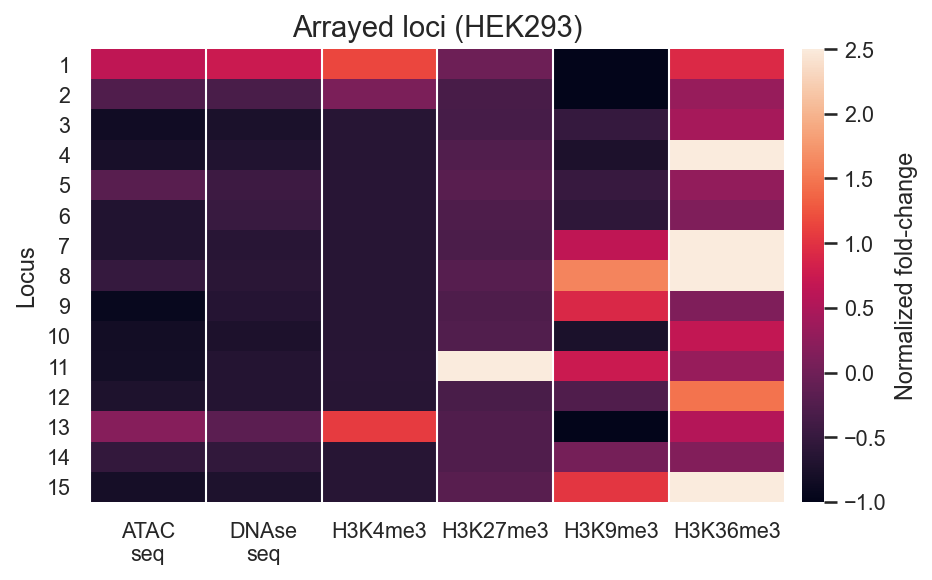

In [298]:
sn.set(font_scale = 0.94)
fig2, ax3 = plt.subplots(figsize=(7.2,4),dpi=150)
ax3.set_title('Arrayed loci (HEK293)', fontsize=titlesize)
labels=['ATAC\nseq','DNAse\nseq', 
       'H3K4me3', 'H3K27me3', 'H3K9me3',
       'H3K36me3']
ylabels=range(1,16)
sn.heatmap(arrayedhek293chromatindf_locusaverage, vmin=-1, vmax=2.5,xticklabels=labels,yticklabels=ylabels, ax=ax3,cbar_kws={'label': 'Normalized fold-change',"pad":0.02})
for i in range(arrayedhek293chromatindf_locusaverage.shape[1]+1):
    ax3.axvline(i, color='white', lw=1)
plt.xticks(rotation=0) 
plt.yticks(rotation=0) 
plt.ylabel("Locus")

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'HEK293_chromatin_levels.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

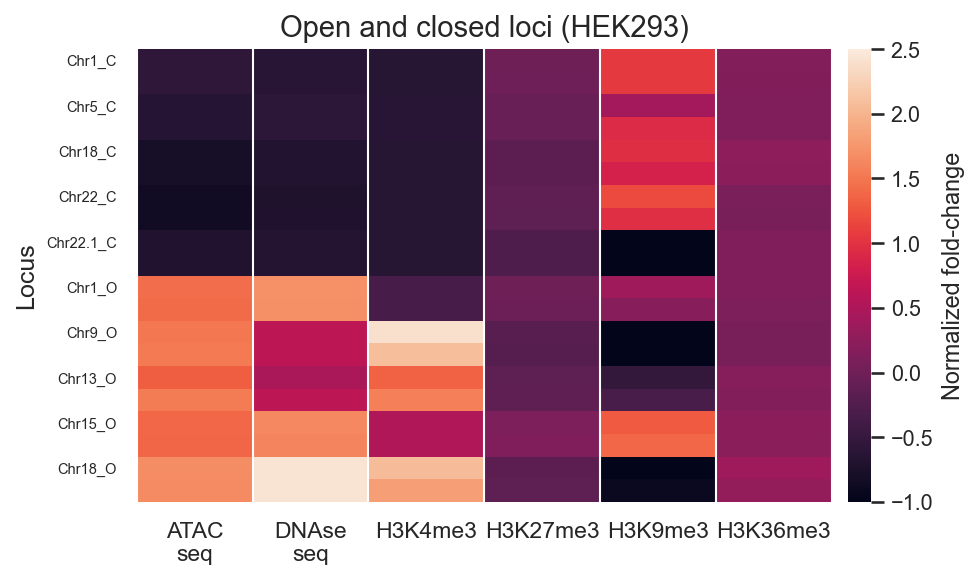

In [299]:
indexlist = ['Chr1_C1', 'Chr1_C2', 'Chr5_C1', 'Chr5_C2',  'Chr18_C1', 'Chr18_C2', 'Chr22_C1', 'Chr22_C2', 'Chr22.1_C1', 'Chr22.1_C2',
           'Chr1_O1','Chr1_O2','Chr9_O1', 'Chr9_O2','Chr13_O1','Chr13_O2',
        'Chr15_O1', 'Chr15_O2',  'Chr18_O1', 'Chr18_O2']
locilist = ['Chr1_C', '', 'Chr5_C', '',  'Chr18_C','',  'Chr22_C', '', 'Chr22.1_C', '',
           'Chr1_O','','Chr9_O','', 'Chr13_O','',
        'Chr15_O','', 'Chr18_O','']

openclosedchromatinleveldf = hek293chromatindf.filter(like='Chr',axis=0).loc[indexlist]

sn.set(font_scale = 0.94)
fig2, ax3 = plt.subplots(figsize=(7.2,4),dpi=150)
ax3.set_title('Open and closed loci (HEK293)', fontsize=titlesize)
labels=['ATAC\nseq','DNAse\nseq', 
       'H3K4me3', 'H3K27me3', 'H3K9me3',
       'H3K36me3']
splt = sn.heatmap(openclosedchromatinleveldf, vmin=-1, vmax=2.5,xticklabels=labels,ax=ax3,cbar_kws={'label': 'Normalized fold-change',"pad":0.02})
for i in range(openclosedchromatinleveldf.shape[1]+1):
    ax3.axvline(i, color='white', lw=1)
splt.set_xticklabels(splt.get_xmajorticklabels(), fontsize = 11)
splt.set_yticklabels(locilist, fontsize = 7)
plt.xticks(rotation=0) 
plt.yticks(rotation=0) 
plt.ylabel("Locus",fontsize=12)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'HEK293_OpenClosed_chromatin_levels.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [300]:
arrayedK562chromatindf = K562chromatindf.filter(like='seq',axis=0).copy()
arrayedK562chromatindf['name'] = arrayedK562chromatindf.index
arrayedK562chromatindf['nr'] = arrayedK562chromatindf['name'].apply(lambda x: int(x[4:]))
arrayedK562chromatindf_locusaverage = pd.DataFrame(columns=list(K562chromatindf.columns))
for x in range(0,44,3):
    for col in K562chromatindf.columns:
        arrayedK562chromatindf_locusaverage.at[x,col] = float(arrayedK562chromatindf[(arrayedK562chromatindf['nr'] == x) | (arrayedK562chromatindf['nr'] == x+1) | (arrayedK562chromatindf['nr'] == x+1)][col].mean())
                                                    
arrayedK562chromatindf_locusaverage = arrayedK562chromatindf_locusaverage.apply(pd.to_numeric, errors='coerce')

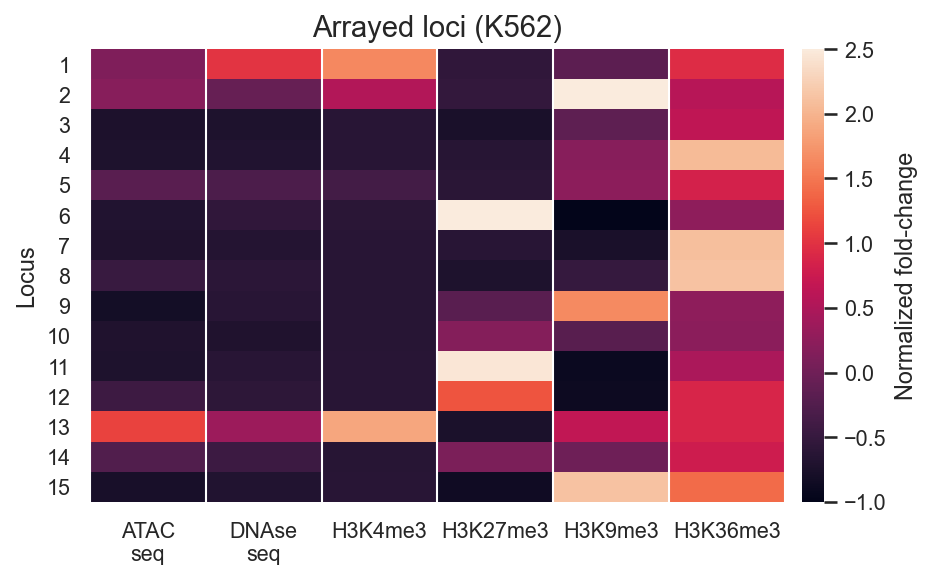

In [301]:
sn.set(font_scale = 0.94)
fig2, ax3 = plt.subplots(figsize=(7.2,4),dpi=150)
ax3.set_title('Arrayed loci (K562)', fontsize=titlesize)
labels=['ATAC\nseq','DNAse\nseq', 
       'H3K4me3', 'H3K27me3', 'H3K9me3',
       'H3K36me3']
ylabels=range(1,16)
sn.heatmap(arrayedK562chromatindf_locusaverage, vmin=-1, vmax=2.5,xticklabels=labels,yticklabels=ylabels, ax=ax3,cbar_kws={'label': 'Normalized fold-change',"pad":0.02})
for i in range(arrayedhek293chromatindf_locusaverage.shape[1]+1):
    ax3.axvline(i, color='white', lw=1)
plt.xticks(rotation=0) 
plt.yticks(rotation=0) 
plt.ylabel("Locus")

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'K562_chromatin_levels.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

### Show HEK293T ATAC-Seq as scatterplots

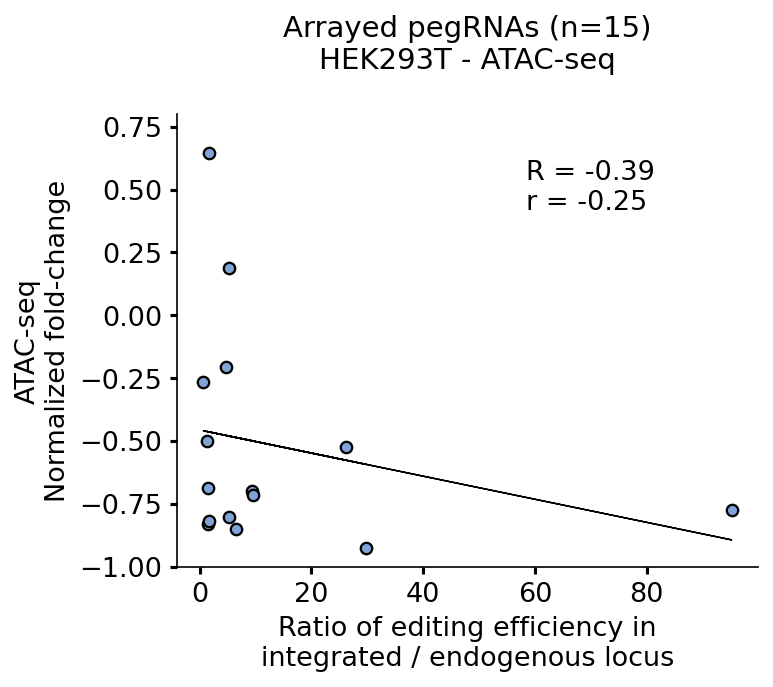

In [302]:
endoonlydf = ahmedpredictionendogenous[ahmedpredictionendogenous['name'].str.contains('endo')].copy()

sn.reset_orig()

endovspridict_R = stats.spearmanr(endoonlydf.ratio_editing_integ_endo,endoonlydf.HEK293_ATAC)[0]
endovspridict_r = stats.pearsonr(endoonlydf.ratio_editing_integ_endo,endoonlydf.HEK293_ATAC)[0]

fig2, ax2 = plt.subplots(figsize=(5,4),dpi=150)
ax2.scatter(endoonlydf.ratio_editing_integ_endo,endoonlydf.HEK293_ATAC, c='#7fa3d4',s=30,edgecolor='black',linewidths=1.1)

ax2.set_title('Arrayed pegRNAs (n=15)\nHEK293T - ATAC-seq\n', fontsize=titlesize)
ax2.set_xlabel('Ratio of editing efficiency in\nintegrated / endogenous locus', fontsize=lsize)
ax2.set_ylabel('ATAC-seq\nNormalized fold-change', fontsize=lsize)
ax2.tick_params(axis='x', labelsize= lsize, width=1.5)
ax2.tick_params(axis='y', labelsize= lsize, width=1.5)
m, b = np.polyfit(endoonlydf.ratio_editing_integ_endo,endoonlydf.HEK293_ATAC, 1)
ax2.plot(endoonlydf.ratio_editing_integ_endo, m*endoonlydf.ratio_editing_integ_endo + b, color='black', linewidth=0.7)
ax2.set_ylim(-1,0.8)
ax2.text(0.6,0.9, 'R = '+str(round(endovspridict_R, 2))+'\nr = '+str(round(endovspridict_r, 2)), transform=ax2.transAxes, fontsize=lsize,
        verticalalignment='top')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'HEK293T_ATAC_Scatter_integrated_endogenous.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

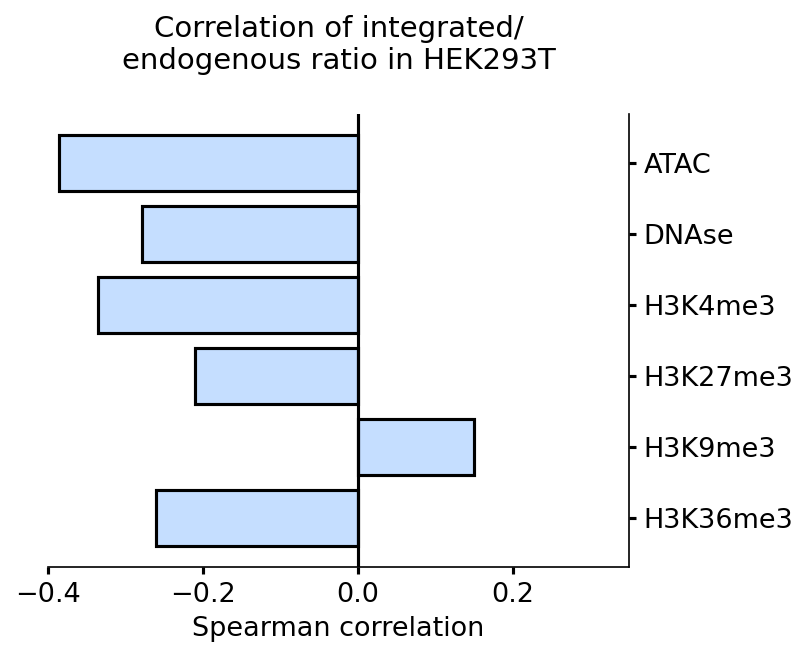

In [303]:
endoonlyhekcorrelationdf = ahmedpredictionendogenous[ahmedpredictionendogenous['name'].str.contains("endo")].corr('spearman')
endoonlyhekcorrelationdf.columns
cols = ['HEK293_ATAC','HEK293_DNAse', 
       'HEK293_H3K4me3', 'HEK293_H3K27me3', 'HEK293_H3K9me3',
       'HEK293_H3K36me3']
endoonlyhekcorrelationdf = endoonlyhekcorrelationdf[cols]
endoonlyhekcorrelationdf.columns = ['ATAC','DNAse','H3K4me3','H3K27me3','H3K9me3','H3K36me3']
endoonlyhekcorrelationdf.loc['ratio_editing_integ_endo',:]
ATAC_HEK45_Spearmanlist = list(endoonlyhekcorrelationdf.loc['ratio_editing_integ_endo',:])
ATAC_HEK45_labels = list(endoonlyhekcorrelationdf.columns)
ATAC_HEK45_Spearmanlist.reverse()
ATAC_HEK45_labels.reverse()

sn.reset_orig()

labels = ATAC_HEK45_labels

fig17, ax17 = plt.subplots(figsize = (5, 4),dpi=150)
ax17.set_title('Correlation of integrated/\nendogenous ratio in HEK293T\n', fontsize=titlesize)
ax17.barh(labels, ATAC_HEK45_Spearmanlist, **bar_kwargs)
ax17.set_xlabel('Spearman correlation', fontsize=lsize)
ax17.spines['left'].set_visible(False)
ax17.spines['top'].set_visible(False)
ax17.yaxis.set_label_position("right")
ax17.yaxis.tick_right()
ax17.axvline(x=0, linewidth=1.5,color='black')
ax17.set_xlim(-0.4,0.35)

ax17.tick_params(axis='x', labelsize= lsize, width=1.5)
ax17.tick_params(axis='y', labelsize= lsize, width=1.5)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'HEK293T_correlation_integrated_endogenous.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

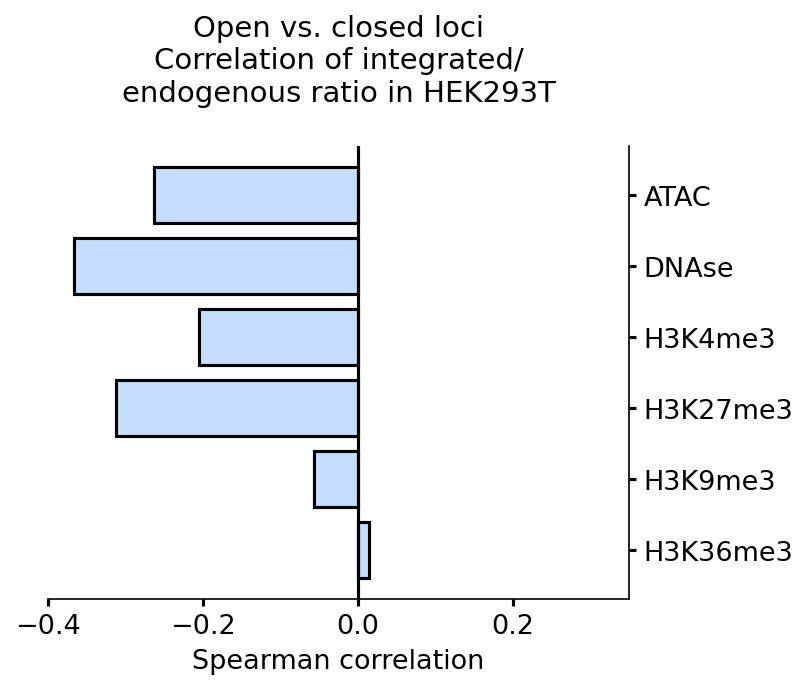

In [304]:
openclosedhekcorrelationdf = openclosedhek293df.corr('spearman')
openclosedhekcorrelationdf.columns
cols = ['HEK293_ATAC','HEK293_DNAse', 
       'HEK293_H3K4me3', 'HEK293_H3K27me3', 'HEK293_H3K9me3',
       'HEK293_H3K36me3']
openclosedhekcorrelationdf = openclosedhekcorrelationdf[cols]
openclosedhekcorrelationdf.loc['ratio_editing_integ_endo',:]
openclosedhekcorrelationdf.columns = ['ATAC','DNAse','H3K4me3','H3K27me3','H3K9me3','H3K36me3']
openclosedlabels = list(openclosedhekcorrelationdf.columns)
openclosedlabels.reverse()
openclosedspearmanlist = list(openclosedhekcorrelationdf.loc['ratio_editing_integ_endo',:])
openclosedspearmanlist.reverse()

sn.reset_orig()

labels = openclosedlabels

fig17, ax17 = plt.subplots(figsize = (5,4),dpi=150)
ax17.set_title('Open vs. closed loci\nCorrelation of integrated/\nendogenous ratio in HEK293T\n', fontsize=titlesize)
ax17.barh(labels, openclosedspearmanlist, **bar_kwargs)
ax17.set_xlabel('Spearman correlation', fontsize=lsize)
ax17.spines['left'].set_visible(False)
ax17.spines['top'].set_visible(False)
ax17.yaxis.set_label_position("right")
ax17.yaxis.tick_right()
#ax17.get_children()[0].set_facecolor('#9AFFB5')
ax17.axvline(x=0, linewidth=1.5,color='black')
ax17.set_xlim(-0.4,0.35)
#ax17.set_yticks(list(np.arange(0.1,1.0,0.2)))
ax17.tick_params(axis='x', labelsize= lsize, width=1.5)
ax17.tick_params(axis='y', labelsize= lsize, width=1.5)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'OpenClosed_correlation_integrated_endogenous.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

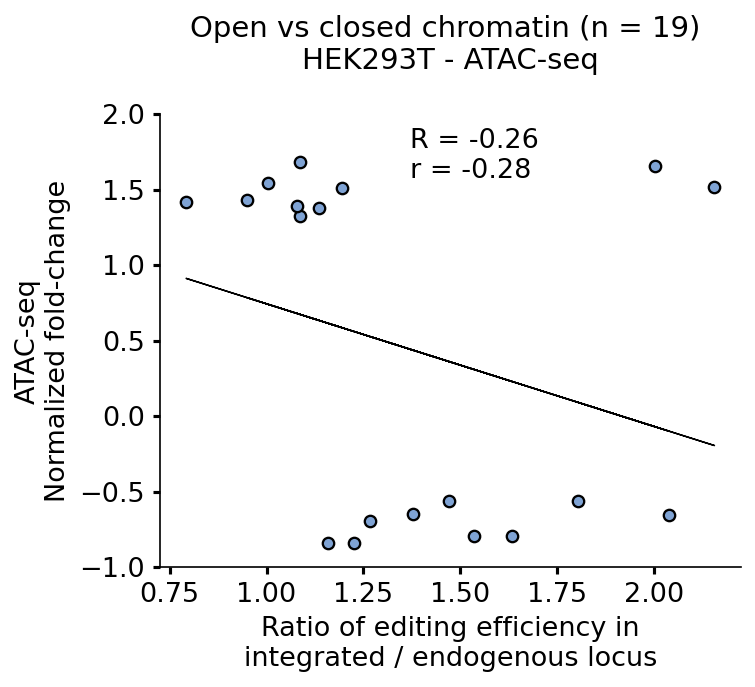

In [305]:
openclosedhek293_integdf = openclosedhek293df.dropna(subset = ['ratio_editing_integ_endo'])

sn.reset_orig()

endovspridict_R = stats.spearmanr(openclosedhek293_integdf.ratio_editing_integ_endo,openclosedhek293_integdf.HEK293_ATAC)[0]
endovspridict_r = stats.pearsonr(openclosedhek293_integdf.ratio_editing_integ_endo,openclosedhek293_integdf.HEK293_ATAC)[0]

fig2, ax2 = plt.subplots(figsize=(5,4),dpi=150)
ax2.scatter(openclosedhek293_integdf.ratio_editing_integ_endo,openclosedhek293_integdf.HEK293_ATAC, c='#7fa3d4',s=30,edgecolor='black',linewidths=1.1)
ax2.set_title('Open vs closed chromatin (n = 19) \nHEK293T - ATAC-seq\n', fontsize=titlesize)
ax2.set_xlabel('Ratio of editing efficiency in\nintegrated / endogenous locus', fontsize=lsize)
ax2.set_ylabel('ATAC-seq\nNormalized fold-change', fontsize=lsize)
ax2.tick_params(axis='x', labelsize= lsize, width=1.5)
ax2.tick_params(axis='y', labelsize= lsize, width=1.5)
ax2.set_ylim(-1,2)
m, b = np.polyfit(openclosedhek293_integdf.ratio_editing_integ_endo,openclosedhek293_integdf.HEK293_ATAC, 1)
ax2.plot(openclosedhek293_integdf.ratio_editing_integ_endo, m*openclosedhek293_integdf.ratio_editing_integ_endo + b, color='black', linewidth=0.7)
ax2.text(0.43,0.97, 'R = '+str(round(endovspridict_R, 2))+'\nr = '+str(round(endovspridict_r, 2)), transform=ax2.transAxes, fontsize=lsize,
        verticalalignment='top')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'openclosed_ATACseq_scatter.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [306]:
cols = ['K562_truescore',
       'pred_averageedited', 'libraryediting', 'ratio_editing_integ_endo',
        'K562_ATAC','K562_DNAse',
       'K562_H3K4me3', 'K562_H3K27me3', 'K562_H3K9me3',
       'K562_H3K36me3']
k562summarydf = ahmedpredictionendogenous.copy()
k562summarydf = k562summarydf.set_index('seq_id')
k562summarydf = k562summarydf[cols]


cols = ['average_between_bio_replicates_endo','pridictscore',
       'average_between_bio_replicates_integ', 'ratio_integ_endo',
       
       '/GSM2902637_K562_hg19_ATAC_no_lysis_buffer.bw','/GSM2902638_K562_hg19_DNase.bw',
       '/K562_hg19_H3K4me3_ENCFF291SWG.bigWig',
       '/K562_hg19_H3K27me3_ENCFF312LYO.bigWig',
       '/K562_hg19_H3K9me3_SRX067527.bw',
       '/K562_hg19_H3K36me3_ENCFF745HXR.bigWig']
k562summarydf2 = opencloseddf.copy()
k562summarydf2 = k562summarydf2.sort_values('Chromatin_state')  # sort by chromatin state for better visualization in heatmap
k562summarydf2 = k562summarydf2[cols]
k562summarydf2['K562_truescore'] = None
k562summarydf2['average_between_bio_replicates_integ'] = None
k562summarydf2['ratio_integ_endo'] = None
k562summarydf2['libraryediting'] = None
k562summarydf2['pred_averageedited'] = k562summarydf2['pridictscore']
cols = ['K562_truescore',
       'pred_averageedited', 'libraryediting', 'ratio_integ_endo',
       '/GSM2902637_K562_hg19_ATAC_no_lysis_buffer.bw','/GSM2902638_K562_hg19_DNase.bw',
       '/K562_hg19_H3K4me3_ENCFF291SWG.bigWig',
       '/K562_hg19_H3K27me3_ENCFF312LYO.bigWig',
       '/K562_hg19_H3K9me3_SRX067527.bw',
       '/K562_hg19_H3K36me3_ENCFF745HXR.bigWig']
k562summarydf2 = k562summarydf2[cols]
k562summarydf2.columns = ['K562_truescore',
       'pred_averageedited', 'libraryediting', 'ratio_editing_integ_endo',
        'K562_ATAC','K562_DNAse',
       'K562_H3K4me3', 'K562_H3K27me3', 'K562_H3K9me3',
       'K562_H3K36me3']

k562summarydf = k562summarydf.append(k562summarydf2)
k562summarydf['libraryediting'] = None
k562summarydf['ratio_editing_integ_endo'] = None


In [307]:
openclosedk562df = k562summarydf.iloc[45:,]
endok562summarydf = k562summarydf.iloc[:45,]

openclosedhek293df = hek293summarydf.iloc[45:,]
endohek293summarydf = hek293summarydf.iloc[:45,]

In [308]:
endok562summarydf['pred_true_ratio'] = endok562summarydf.apply(lambda x: 'low' if x.pred_averageedited > 50 and x.K562_truescore < 5 else ('high' if x.pred_averageedited > 50 and x.K562_truescore > 5 else None)  ,axis=1)
endohek293summarydf['pred_true_ratio'] = endohek293summarydf.apply(lambda x: 'low' if x.pred_averageedited > 50 and x.true_averageedited < 22 else ('high' if x.pred_averageedited > 50 and x.true_averageedited > 40 else None)  ,axis=1)


HEK_inhibited_editing_dict = {}
for x in ['high','low']:
    HEK_inhibited_editing_dict[x] = []
    chromatinmarks = [ 'HEK293_ATAC','HEK293_DNAse',
       'HEK293_H3K4me3', 'HEK293_H3K27me3', 'HEK293_H3K9me3',
       'HEK293_H3K36me3']
    for mark in chromatinmarks:
        HEK_inhibited_editing_dict[x].append(endohek293summarydf[endohek293summarydf['pred_true_ratio'] == x][mark].mean())
        
K562_inhibited_editing_dict = {}
for x in ['high','low']:
    K562_inhibited_editing_dict[x] = []
    chromatinmarks = [ 'K562_ATAC','K562_DNAse',
       'K562_H3K4me3', 'K562_H3K27me3', 'K562_H3K9me3',
       'K562_H3K36me3']
    for mark in chromatinmarks:
        K562_inhibited_editing_dict[x].append(endok562summarydf[endok562summarydf['pred_true_ratio'] == x][mark].mean())

C:\Users\nimath\AppData\Local\Temp/ipykernel_14344/2011931004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endok562summarydf['pred_true_ratio'] = endok562summarydf.apply(lambda x: 'low' if x.pred_averageedited > 50 and x.K562_truescore < 5 else ('high' if x.pred_averageedited > 50 and x.K562_truescore > 5 else None)  ,axis=1)
C:\Users\nimath\AppData\Local\Temp/ipykernel_14344/2011931004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endohek293summarydf['pred_true_ratio'] = endohek293summarydf.ap

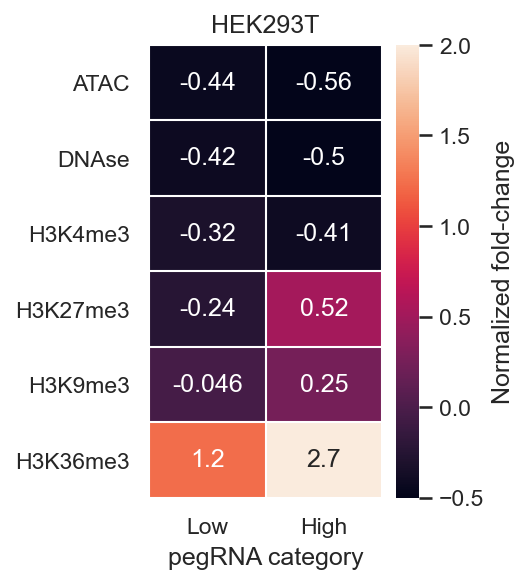

In [309]:
sn.set(font_scale = 1)

HEK_inhibited_editing_df = pd.DataFrame(columns = [ 'HEK293_ATAC','HEK293_DNAse',
       'HEK293_H3K4me3', 'HEK293_H3K27me3', 'HEK293_H3K9me3',
       'HEK293_H3K36me3'])

chromatinmarklist = [ 'ATAC','DNAse',
       'H3K4me3', 'H3K27me3', 'H3K9me3',
       'H3K36me3']

HEK_inhibited_editing_df.loc['Low',:] = HEK_inhibited_editing_dict['low']
HEK_inhibited_editing_df.loc['High',:] = HEK_inhibited_editing_dict['high']
HEK_inhibited_editing_df = HEK_inhibited_editing_df.apply(pd.to_numeric)
HEK_inhibited_editing_df_transposed = HEK_inhibited_editing_df.transpose()

fig2, ax3 = plt.subplots(figsize=(2.5,4),dpi=150)
sn.heatmap(HEK_inhibited_editing_df_transposed,annot=True, yticklabels=chromatinmarklist,ax=ax3,vmin=-0.5,vmax=2,cbar_kws={'label': 'Normalized fold-change'})
ax3.set_title('HEK293T')
plt.yticks(rotation=0)
for i in range(HEK_inhibited_editing_df_transposed.shape[1]+1):
    ax3.axvline(i, color='white', lw=1)
for i in range(HEK_inhibited_editing_df_transposed.shape[0]+1):
    ax3.axhline(i, color='white', lw=1)
ax3.set_xlabel('pegRNA category')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'HEK293Tendo_low_high_chromatin.pdf', format='pdf',
        transparent=True,bbox_inches='tight')



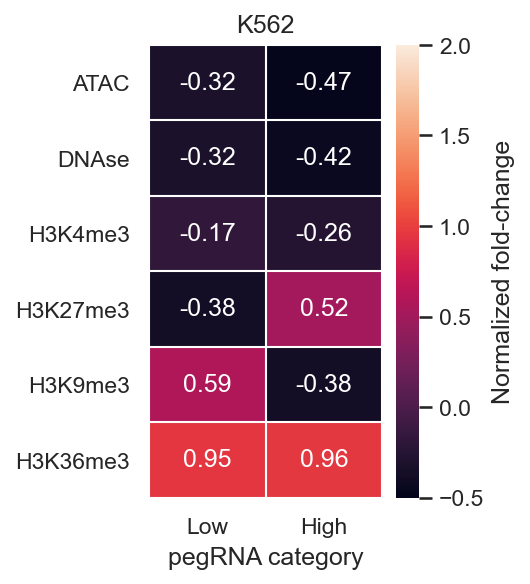

In [310]:
sn.set(font_scale = 1)
K562_inhibited_editing_df = pd.DataFrame(columns = [ 'K562_ATAC','K562_DNAse',
       'K562_H3K4me3', 'K562_H3K27me3', 'K562_H3K9me3',
       'K562_H3K36me3'])

chromatinmarklist = ['ATAC','DNAse',
       'H3K4me3', 'H3K27me3', 'H3K9me3',
       'H3K36me3']
K562_inhibited_editing_df.loc['Low',:] = K562_inhibited_editing_dict['low']
K562_inhibited_editing_df.loc['High',:] = K562_inhibited_editing_dict['high']

K562_inhibited_editing_df = K562_inhibited_editing_df.apply(pd.to_numeric)
K562_inhibited_editing_df_transposed = K562_inhibited_editing_df.transpose()


fig2, ax3 = plt.subplots(figsize=(2.5,4),dpi=150)
sn.heatmap(K562_inhibited_editing_df_transposed,annot=True, yticklabels=chromatinmarklist,ax=ax3,vmin=-0.5,vmax=2,cbar_kws={'label': 'Normalized fold-change'})
ax3.set_title('K562')
plt.yticks(rotation=0)
for i in range(K562_inhibited_editing_df_transposed.shape[1]+1):
    ax3.axvline(i, color='white', lw=1)
for i in range(K562_inhibited_editing_df_transposed.shape[0]+1):
    ax3.axhline(i, color='white', lw=1)
ax3.set_xlabel('pegRNA category')

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup16_Endogenous_Additional\\'
plt.savefig(figurepath+'K562endo_low_high_chromatin.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

### Comparison Kim et al. RTT overhang vs. Schwank vs. Anzalone

In [311]:
path = "C:\\Users\\nimath\\switchdrive\\PE_schwank\\"
kimetalfeaturedf = pd.read_csv(path+'20220818_featuredf_hyongbum.csv')
schwankfeaturedf = pd.read_csv(path+'20220719_featuredf_focused_withindex.csv')
anzalonefeaturedf = pd.read_csv(path+'20220819_anzalone_featuredf.csv')

kimetalfeaturedf['averageedited'] = kimetalfeaturedf['EDIT_EFFICIENCY']
anzalonefeaturedf.averageedited = anzalonefeaturedf.averageedited.apply(lambda x: x*100)

schwankgtocdf = schwankfeaturedf[(schwankfeaturedf['AlternateAllele'] == "G") & (schwankfeaturedf['ReferenceAllele'] == "C") & (schwankfeaturedf['Editing_Position'] == 4)].copy()

135
135
137
133


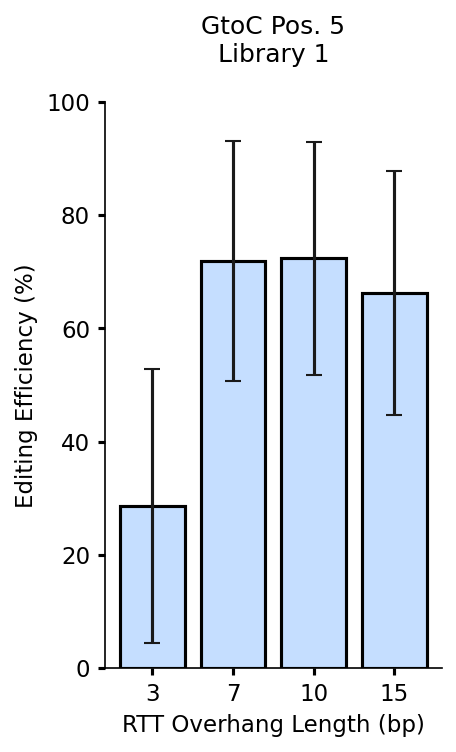

In [317]:
sn.reset_orig()

RTToverhangtemplist = []
RTToverhangmeanlist = []
RTToverhangstddevlist = []
RTToverhangindividual = []
uniqueRTToverhanglengthlist = list(schwankgtocdf.RToverhanglength.unique())
uniqueRTToverhanglengthlist = sorted(uniqueRTToverhanglengthlist)
for temp in uniqueRTToverhanglengthlist:
    RTToverhangtemplist.append(str(int(temp)))
    lengthdf = schwankgtocdf[schwankgtocdf['RToverhanglength'] == temp].copy()
    mean = lengthdf.averageedited.mean()
    std = lengthdf.averageedited.std()
    individual = list(lengthdf.averageedited)
    RTToverhangmeanlist.append(mean)
    RTToverhangstddevlist.append(std)
    RTToverhangindividual.append(individual)

fig2, ax3 = plt.subplots(figsize=(2.9,5),dpi=150)
ax3.set_title('GtoC Pos. 5\nLibrary 1\n', fontsize=12)
ax3.bar(RTToverhangtemplist,RTToverhangmeanlist, yerr=RTToverhangstddevlist, **bar_kwargs)

ax3.set_ylabel('Editing Efficiency (%)', fontsize=11)
ax3.set_xlabel('RTT Overhang Length (bp)', fontsize=11)

ax3.tick_params(axis='x', labelsize= 11, width=1.5)
ax3.tick_params(axis='y', labelsize= 11, width=1.5)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.set_ylim(0, 100)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'RTToverhanglengths_GtoC_Mathisetal.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

for entry in RTToverhangindividual:
    print(len(entry))

10746
10828
10921
10654


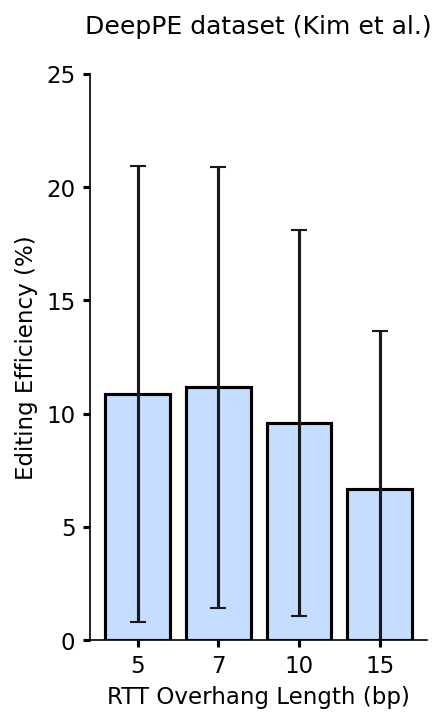

In [318]:
RTToverhangtemplist = []
RTToverhangmeanlist = []
RTToverhangstddevlist = []
RTToverhangindividual = []
uniqueRTToverhanglengthlist = list(kimetalfeaturedf.RToverhanglength.unique())
uniqueRTToverhanglengthlist = sorted(uniqueRTToverhanglengthlist)
for temp in uniqueRTToverhanglengthlist:
    RTToverhangtemplist.append(str(int(temp)))
    lengthdf = kimetalfeaturedf[kimetalfeaturedf['RToverhanglength'] == temp].copy()
    mean = lengthdf.averageedited.mean()
    std = lengthdf.averageedited.std()
    individual = list(lengthdf.averageedited)
    RTToverhangmeanlist.append(mean)
    RTToverhangstddevlist.append(std)
    RTToverhangindividual.append(individual)

fig2, ax3 = plt.subplots(figsize=(2.9,5),dpi=150)
ax3.set_title('DeepPE dataset (Kim et al.)\n', fontsize=12)
ax3.bar(RTToverhangtemplist,RTToverhangmeanlist, yerr=RTToverhangstddevlist, **bar_kwargs)

ax3.set_ylabel('Editing Efficiency (%)', fontsize=11)
ax3.set_xlabel('RTT Overhang Length (bp)', fontsize=11)

ax3.tick_params(axis='x', labelsize= 11, width=1.5)
ax3.tick_params(axis='y', labelsize= 11, width=1.5)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.set_ylim(0, 25)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup8_Validation\\'
plt.savefig(figurepath+'RTToverhanglengths_DeepPE_Kimetal.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

for entry in RTToverhangindividual:
    print(len(entry))